# Imports

In [2]:
%reload_ext autoreload
%autoreload 2

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import os
from glob import glob
from tqdm import tqdm
import pickle

from sklearn.preprocessing import StandardScaler
from scipy.stats import pearsonr, spearmanr
from sklearn.metrics import r2_score

import warnings
warnings.filterwarnings("ignore")

In [4]:
from data_transformation import CleanData
from features_library import FeatureTransformations
from regression import (
                        BaseReg,
                        RandomForestReg, 
                        HistGradientBoostingReg, 
                        SGDReg, 
                        ElasticNetReg, 
                        TheilSenReg,
                        RANSACReg
                        )
from trading_strategies import TradingStrategy
from performance_metrics import PerformanceMetrics

# Load Data

In [5]:
DIR_CRYPTO_DATA = "./data/1_Crypto_data/"
DIR_FINANCIAL_DATA = "./data/1_Financial_component_data/"

In [6]:
dict_assets = {}
ASSETS_SELECTED = [
    'BTC-USD',
    'ETH-USD',
    'XRP-USD',
    'LTC-USD',
]

for file_crypto in glob(f"{DIR_CRYPTO_DATA}*.csv"):

    # Read CSV
    asset_name = os.path.basename(file_crypto).split(".")[0]
    if not asset_name in ASSETS_SELECTED:
        continue
    df_asset = pd.read_csv(file_crypto)

    # Pre-Process Data
    preproc = CleanData(df_asset)
    preproc.make_datetime_index(date_col='Date')
    preproc.resample(freq='1D')
    preproc.strip_column_name()

    # assign to dict
    dict_assets[asset_name] = preproc.df


In [7]:
dict_fd = {}
for file_fd in glob(f"{DIR_FINANCIAL_DATA}*.csv"):

    # Read CSV
    fd_name = os.path.basename(file_fd).split(".")[0]
    df_fd = pd.read_csv(file_fd)

    if fd_name.startswith("F-F"):
        df_fd = df_fd.loc[df_fd['Date']>19700101]
        df_fd["Date"] = df_fd["Date"].astype(str)
        df_fd["Date"] = df_fd["Date"].apply(lambda x: f"{x[:4]}-{x[4:6]}-{x[6:8]}")

    # Pre-Process Data
    preproc = CleanData(df_fd)
    preproc.make_datetime_index(date_col='Date')
    preproc.resample(freq='1D')
    preproc.strip_column_name()
    preproc.ffill()

    # Keep??
    # if ('Adj Close' not in df_fd.columns) and ('Close' in df_fd.columns):
    #     df_fd['Adj Close'] = df_fd['Close'].copy()

    # assign to dict
    dict_fd[fd_name] = preproc.df

In [8]:
df_risk_free = pd.read_excel(os.path.join(DIR_FINANCIAL_DATA, "RiskFree.xls"))
df_risk_free.index = df_risk_free['TcmDate']
df_risk_free.index.name = None
df_risk_free = df_risk_free[['Tcm1mo', 'Tcm3mo', 'Tcm1yr', 'Tcm5yr', 'Tcm10yr']]
df_risk_free = df_risk_free.resample('1D').first().ffill()
df_risk_free

Tcm1mo  Tcm3mo  Tcm1yr  Tcm5yr  Tcm10yr
1997-01-02  0.0519  0.0519  0.0563  0.0630   0.0654
1997-01-03  0.0517  0.0517  0.0560  0.0628   0.0652
1997-01-04  0.0517  0.0517  0.0560  0.0628   0.0652
1997-01-05  0.0517  0.0517  0.0560  0.0628   0.0652
1997-01-06  0.0517  0.0517  0.0561  0.0630   0.0654
...            ...     ...     ...     ...      ...
2023-03-16  0.0422  0.0474  0.0449  0.0372   0.0356
2023-03-17  0.0431  0.0452  0.0426  0.0344   0.0339
2023-03-18  0.0431  0.0452  0.0426  0.0344   0.0339
2023-03-19  0.0431  0.0452  0.0426  0.0344   0.0339
2023-03-20  0.0434  0.0481  0.0434  0.0356   0.0347

[9574 rows x 5 columns]

# Feature Engineering

## Make Feature Transformations

For Assets, apply all feature transformations

In [9]:
for asset in dict_assets:
    feature_transformer = FeatureTransformations(dict_assets[asset])
    feature_transformer.transform_assets()
    dict_assets[asset] = feature_transformer.df_asset

For S&P500, apply selected feature transformations

In [10]:
dict_fd['S_P 500 index']['Volume'] = np.nan
# dict_fd['S_P 500 index'] = dict_fd['S_P 500 index'].ffill()
feature_transformer = FeatureTransformations(dict_fd['S_P 500 index'])
feature_transformer.transform_snp500()
dict_fd['S_P 500 index'] = feature_transformer.df_asset
dict_fd['S_P 500 index'].drop(columns=['Volume'], inplace=True)

## Add Financial Data to assets

In [11]:
for asset_name, df_asset in dict_assets.items():
    
    ASSET_START_PERIOD = df_asset.index.min()
    ASSET_END_PERIOD = df_asset.index.max()

    for financial_dataset, df_fd in dict_fd.items():

        df_fd = df_fd[ASSET_START_PERIOD:ASSET_END_PERIOD]
        
        rename_fd_cols = {column: f"{financial_dataset}_{column}".replace(" ", "_") for column in df_fd.columns}
        df_fd.rename(columns=rename_fd_cols, inplace=True)
        df_asset = pd.concat([df_asset, df_fd], axis=1)
    
    # add risk-free info
    df_asset = pd.concat([df_asset, df_risk_free[ASSET_START_PERIOD:ASSET_END_PERIOD]], axis=1)
    
    dict_assets[asset_name] = df_asset

## Normalize Features

In [11]:
# for asset_name, df_asset in dict_assets.items():
#     scaler = StandardScaler()
#     df_asset[df_asset.columns] = scaler.fit_transform(df_asset)
#     dict_assets[asset_name] = df_asset

# EDA Plots

## Describe Price Movements

Plot of close price trends with high-low indicators

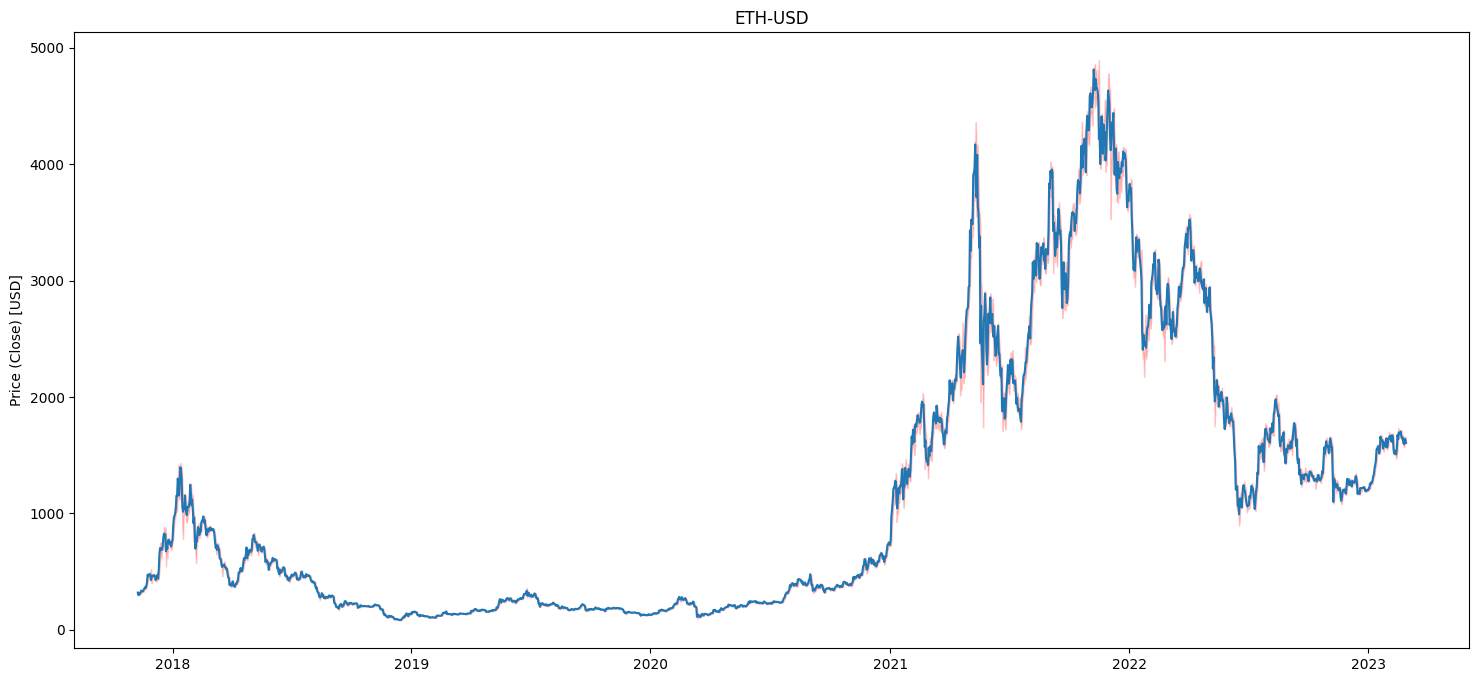

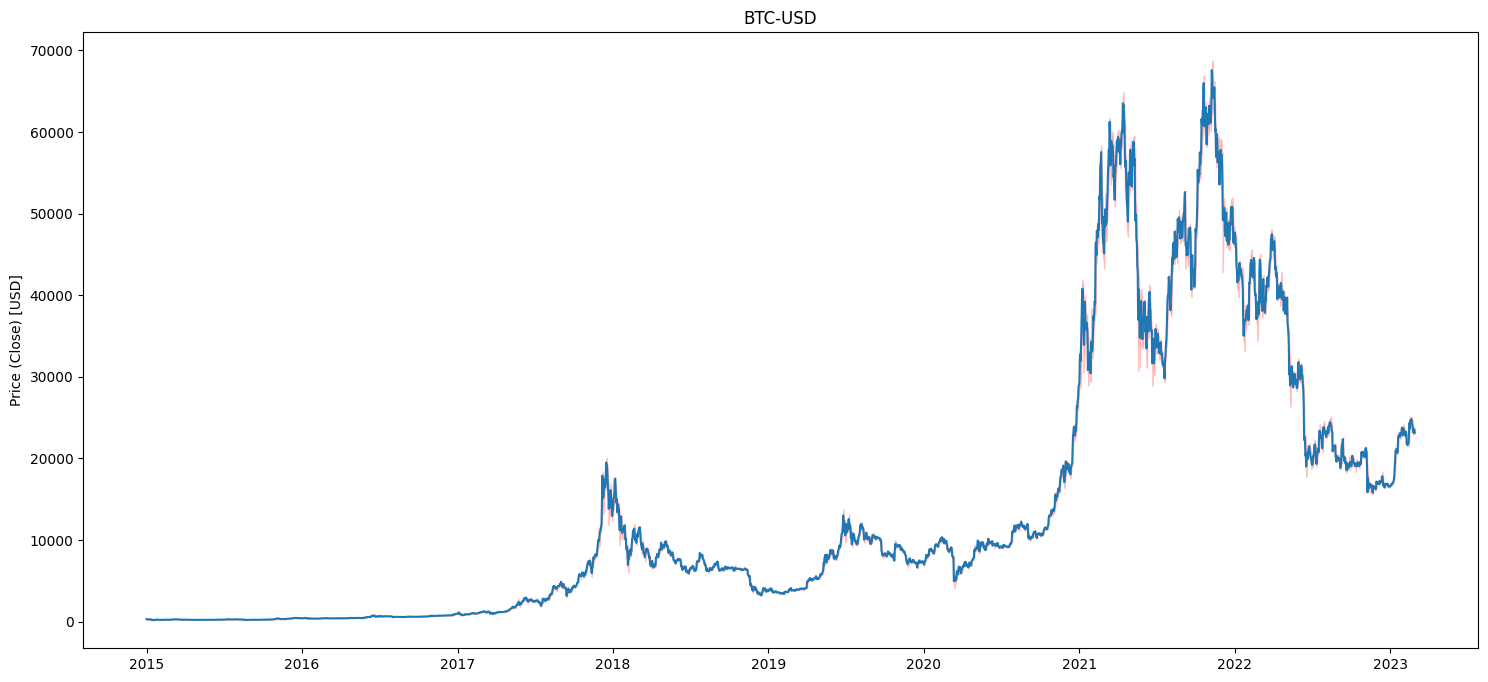

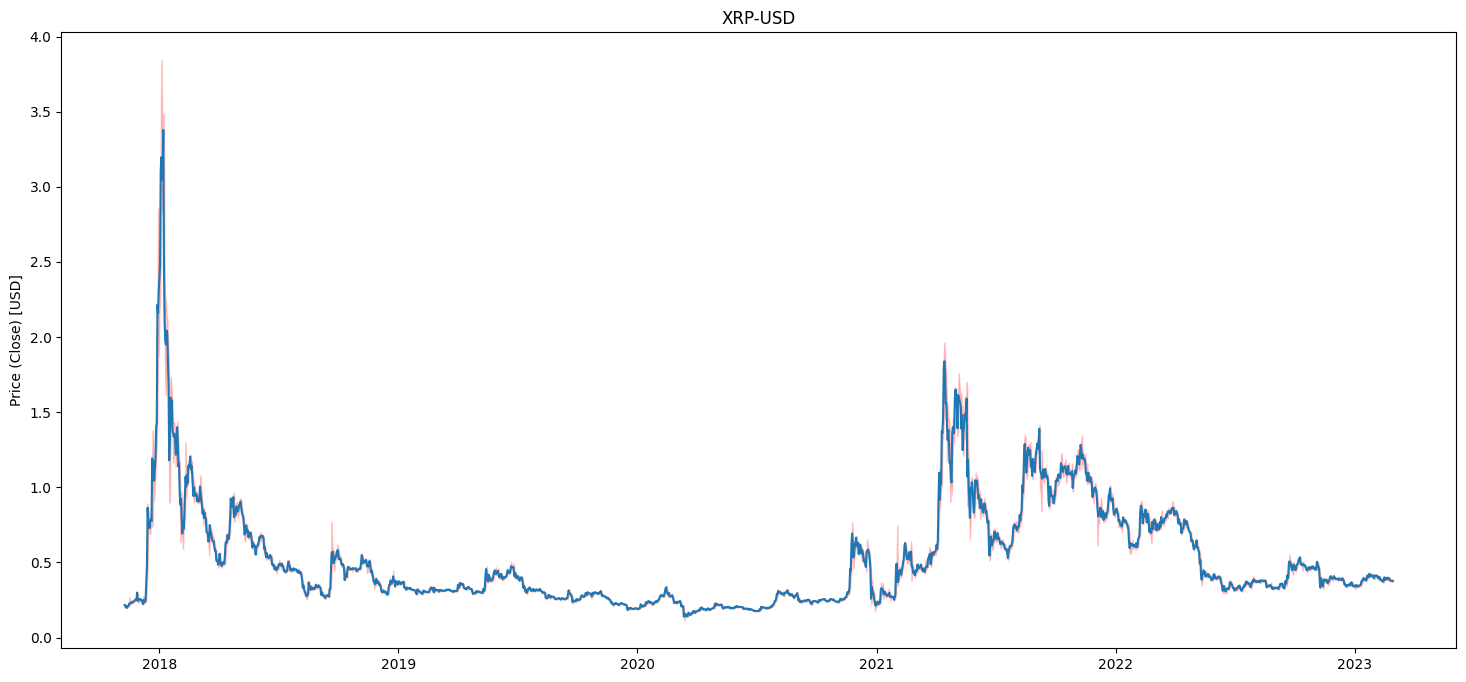

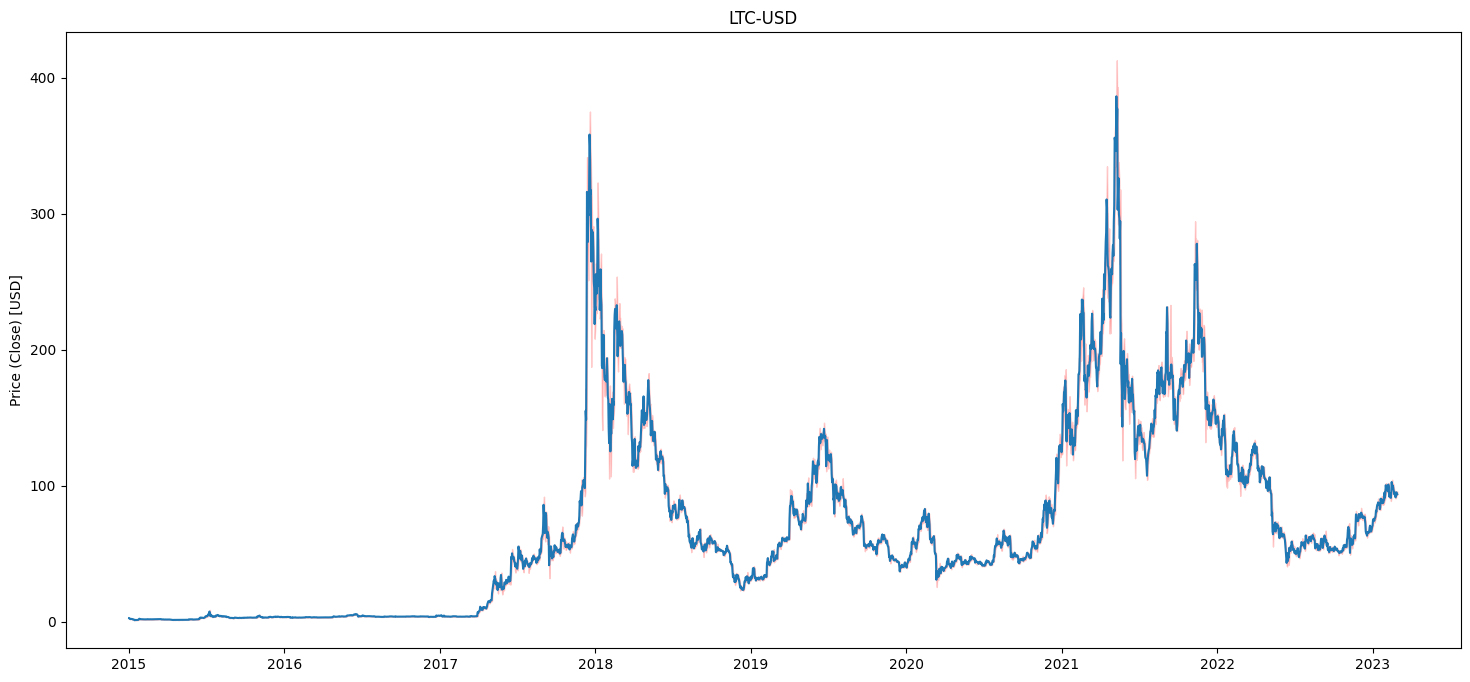

In [12]:
nrows = len(df_asset)
ncols = 1


for idx, (asset_name, df_asset) in enumerate(dict_assets.items()):
    fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(18, 8))
    df_plot = df_asset#['2022-01-01': '2022-06-30']
    ax.plot(df_plot['Close'])

    ax.fill_between(
        df_plot.index, 
        df_plot['High'], 
        df_plot['Low'], 
        alpha=0.2,
        color='red',
        interpolate=False,
        )
    ax.set_title(asset_name)
    ax.set_ylabel("Price (Close) [USD]")
    
    plt.show()

Plot of close price trends of all assets

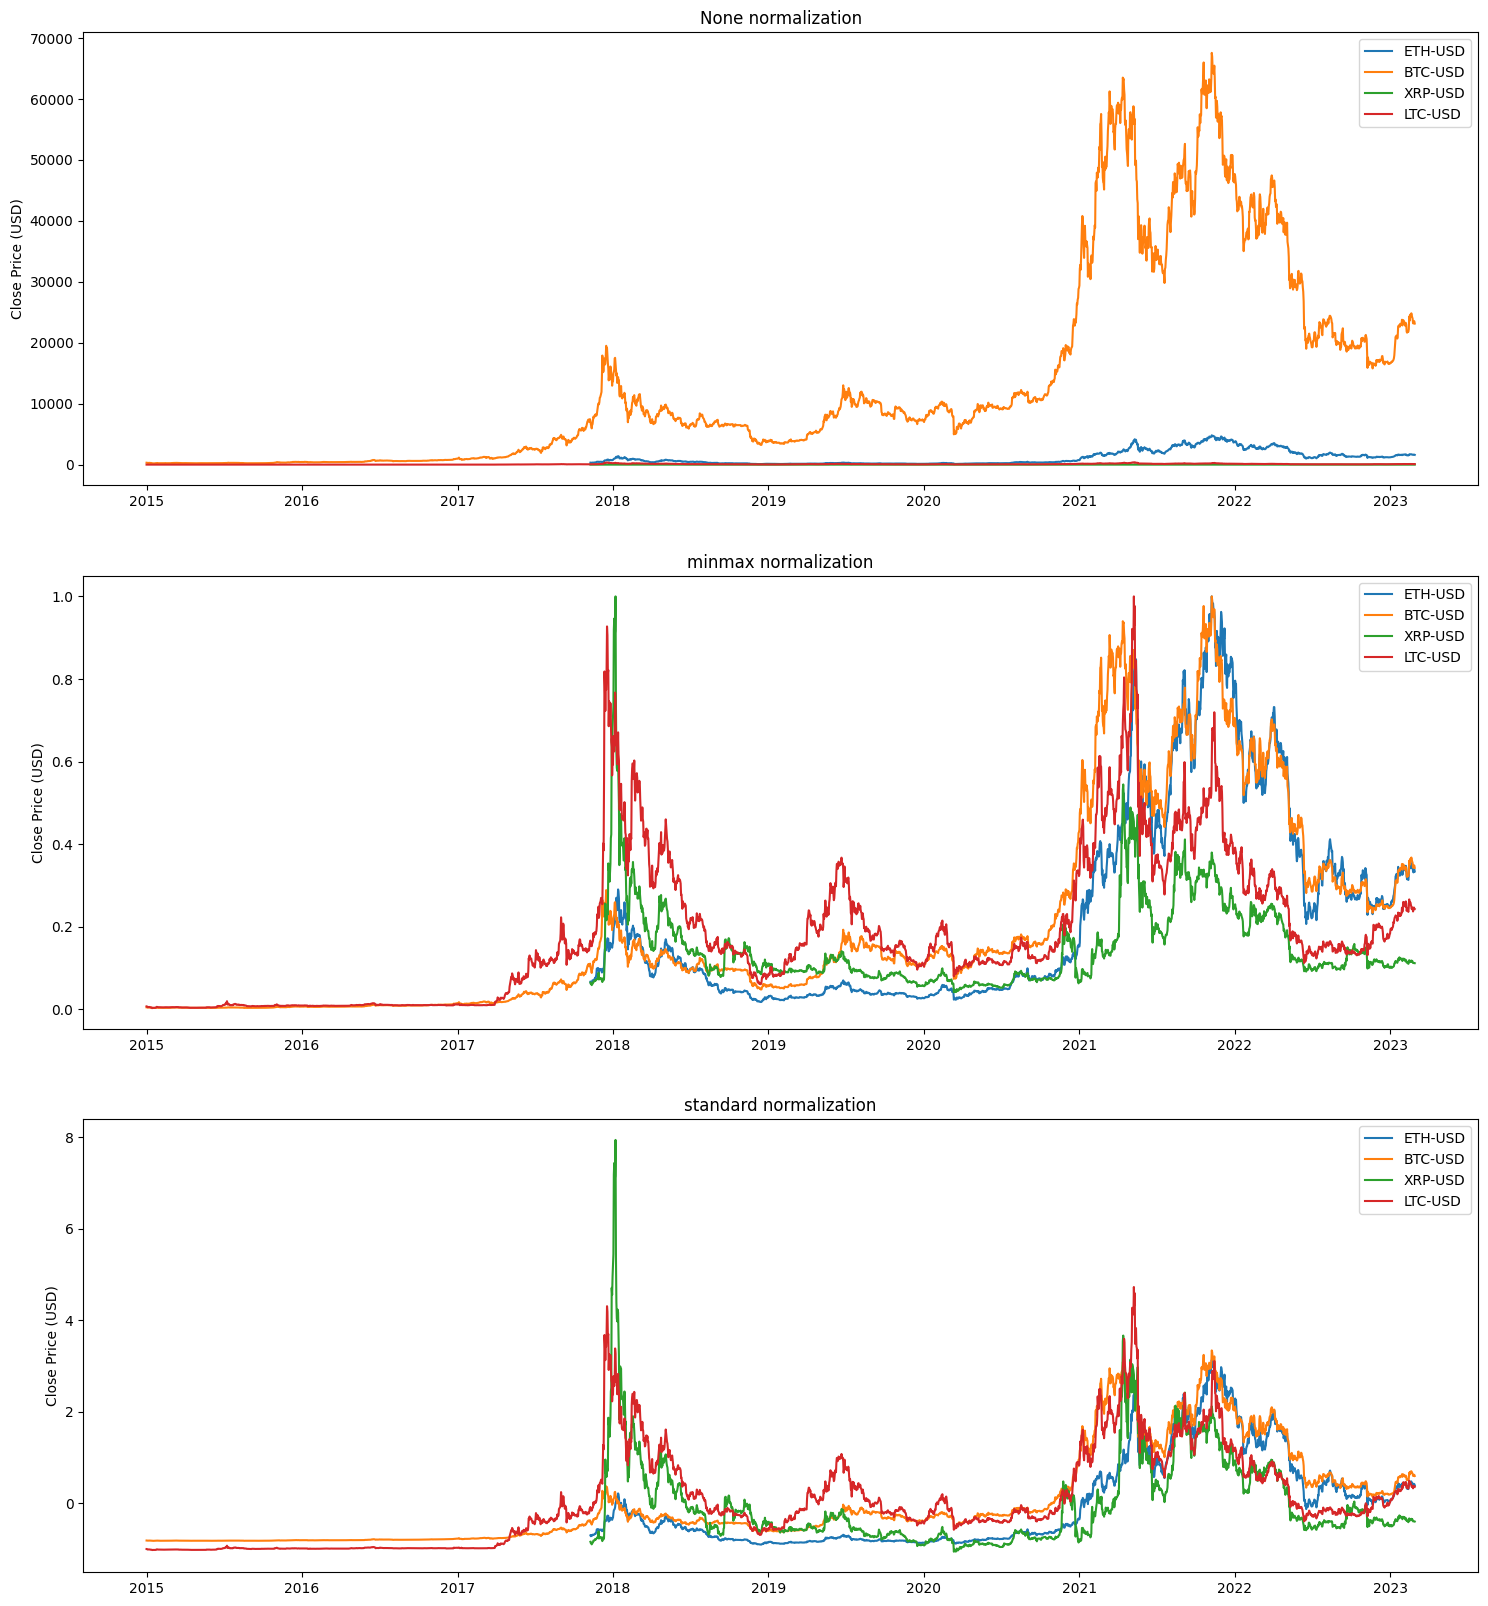

In [13]:
NORM = [None, 'minmax', 'standard']

nrows, ncols = len(NORM), 1
fig, axs = plt.subplots(ncols=ncols, nrows=nrows, figsize=(18, 20))

colormap = plt.cm.nipy_spectral
colors = colormap(np.linspace(0, 1, len(dict_assets)))
ax.set_prop_cycle('color', colors)

for idx, (asset_name, df_asset) in enumerate(dict_assets.items()):
    # if asset_name == 'BTC-USD':
    #     continue
    df_plot = df_asset # ['2021-01-01':]
    for idx, norm_method in enumerate(NORM):
        ax = axs[idx]
        if norm_method==None:
            ax.plot(df_plot['Close'], label=asset_name)
        
        elif norm_method=='minmax':
            ax.plot(df_plot['Close']/df_plot['Close'].max(), label=asset_name)
        elif norm_method=='standard':
            standard_scaler = StandardScaler()
            ax.plot(
                pd.Series(
                    standard_scaler.fit_transform(df_plot['Close'].values.reshape(-1, 1)).reshape(1,-1)[0],
                    index=df_plot['Close'].index
                    ), 
                    label=asset_name)
        ax.set_title(f"{str(norm_method)} normalization")
        ax.set_ylabel(f"Close Price (USD)")
        ax.legend()

plt.show()

## Describe Returns

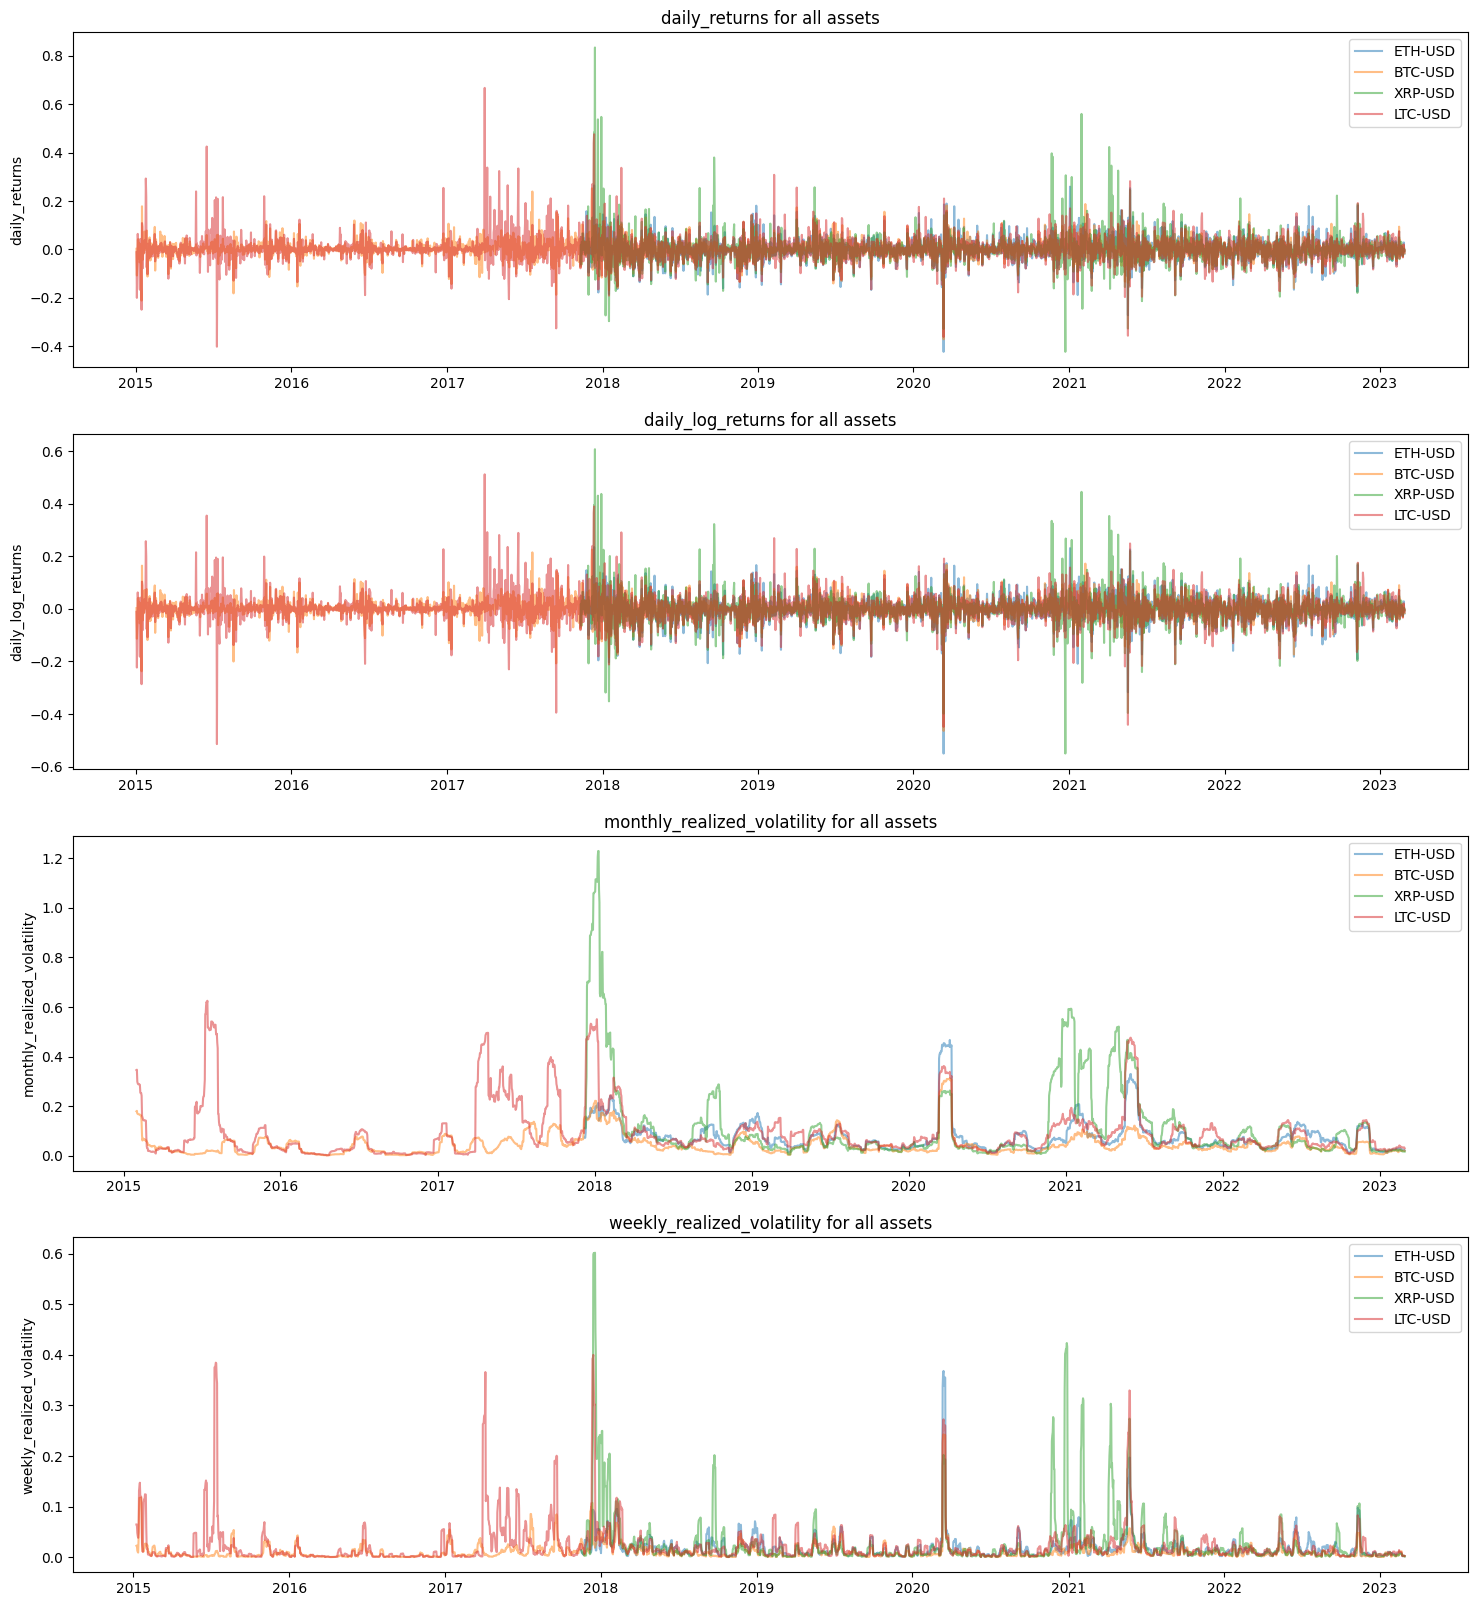

In [14]:
RETURN_VARS = ['daily_returns', 'daily_log_returns', 'monthly_realized_volatility', 'weekly_realized_volatility']

nrows, ncols = len(RETURN_VARS), 1
fig, axs = plt.subplots(ncols=ncols, nrows=nrows, figsize=(18, 20))

colormap = plt.cm.nipy_spectral
colors = colormap(np.linspace(0, 1, len(dict_assets)))
ax.set_prop_cycle('color', colors)

for idx, return_var in enumerate(RETURN_VARS):
    ax = axs[idx]
    for asset_name, df_asset in dict_assets.items():
        # if asset_name == 'BTC-USD':
        #     continue
        df_plot = df_asset#['2021-01-01':]
        ax.plot(df_plot[return_var], label=asset_name, alpha=0.5)
        
    ax.set_title(f"{str(return_var)} for all assets")
    ax.set_ylabel(str(return_var))
    ax.legend(loc='upper right')
    
plt.show()

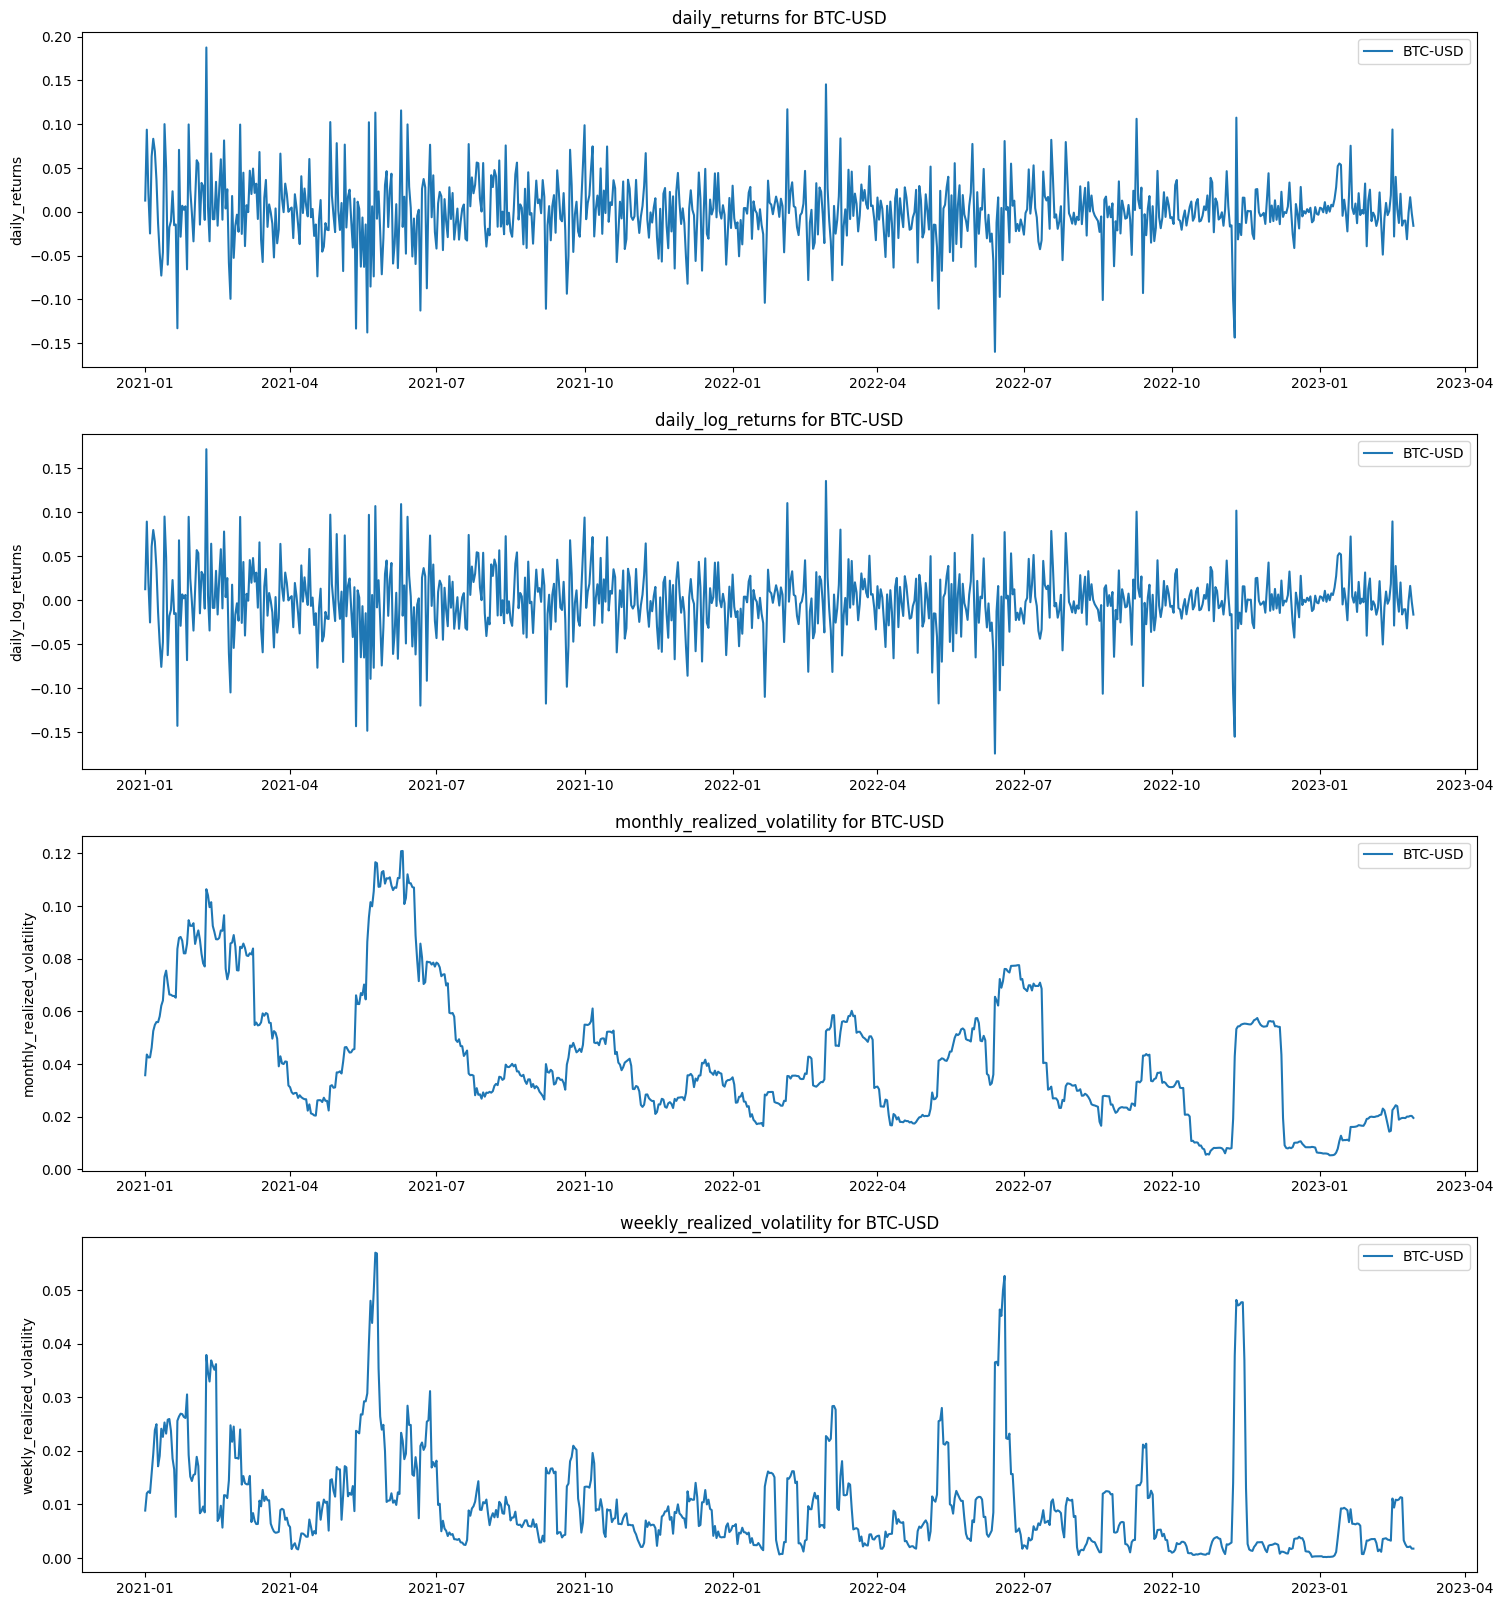

In [15]:
RETURN_VARS = ['daily_returns', 'daily_log_returns', 'monthly_realized_volatility', 'weekly_realized_volatility']
ASSET_NAME = 'BTC-USD'

nrows, ncols = len(RETURN_VARS), 1
fig, axs = plt.subplots(ncols=ncols, nrows=nrows, figsize=(18, 20))

colormap = plt.cm.nipy_spectral
colors = colormap(np.linspace(0, 1, len(dict_assets)))
ax.set_prop_cycle('color', colors)

for idx, return_var in enumerate(RETURN_VARS):
    ax = axs[idx]
    df_asset = dict_assets[ASSET_NAME]
    df_plot = df_asset['2021-01-01':]
    ax.plot(df_plot[return_var], label=ASSET_NAME)

    ax.set_title(f"{str(return_var)} for {ASSET_NAME}")
    ax.set_ylabel(str(return_var))
    ax.legend()

plt.show()

## Correlation

Correlations between explanatory variables of each asset

In [26]:
df_asset = dict_assets['BTC-USD']

<Axes: >

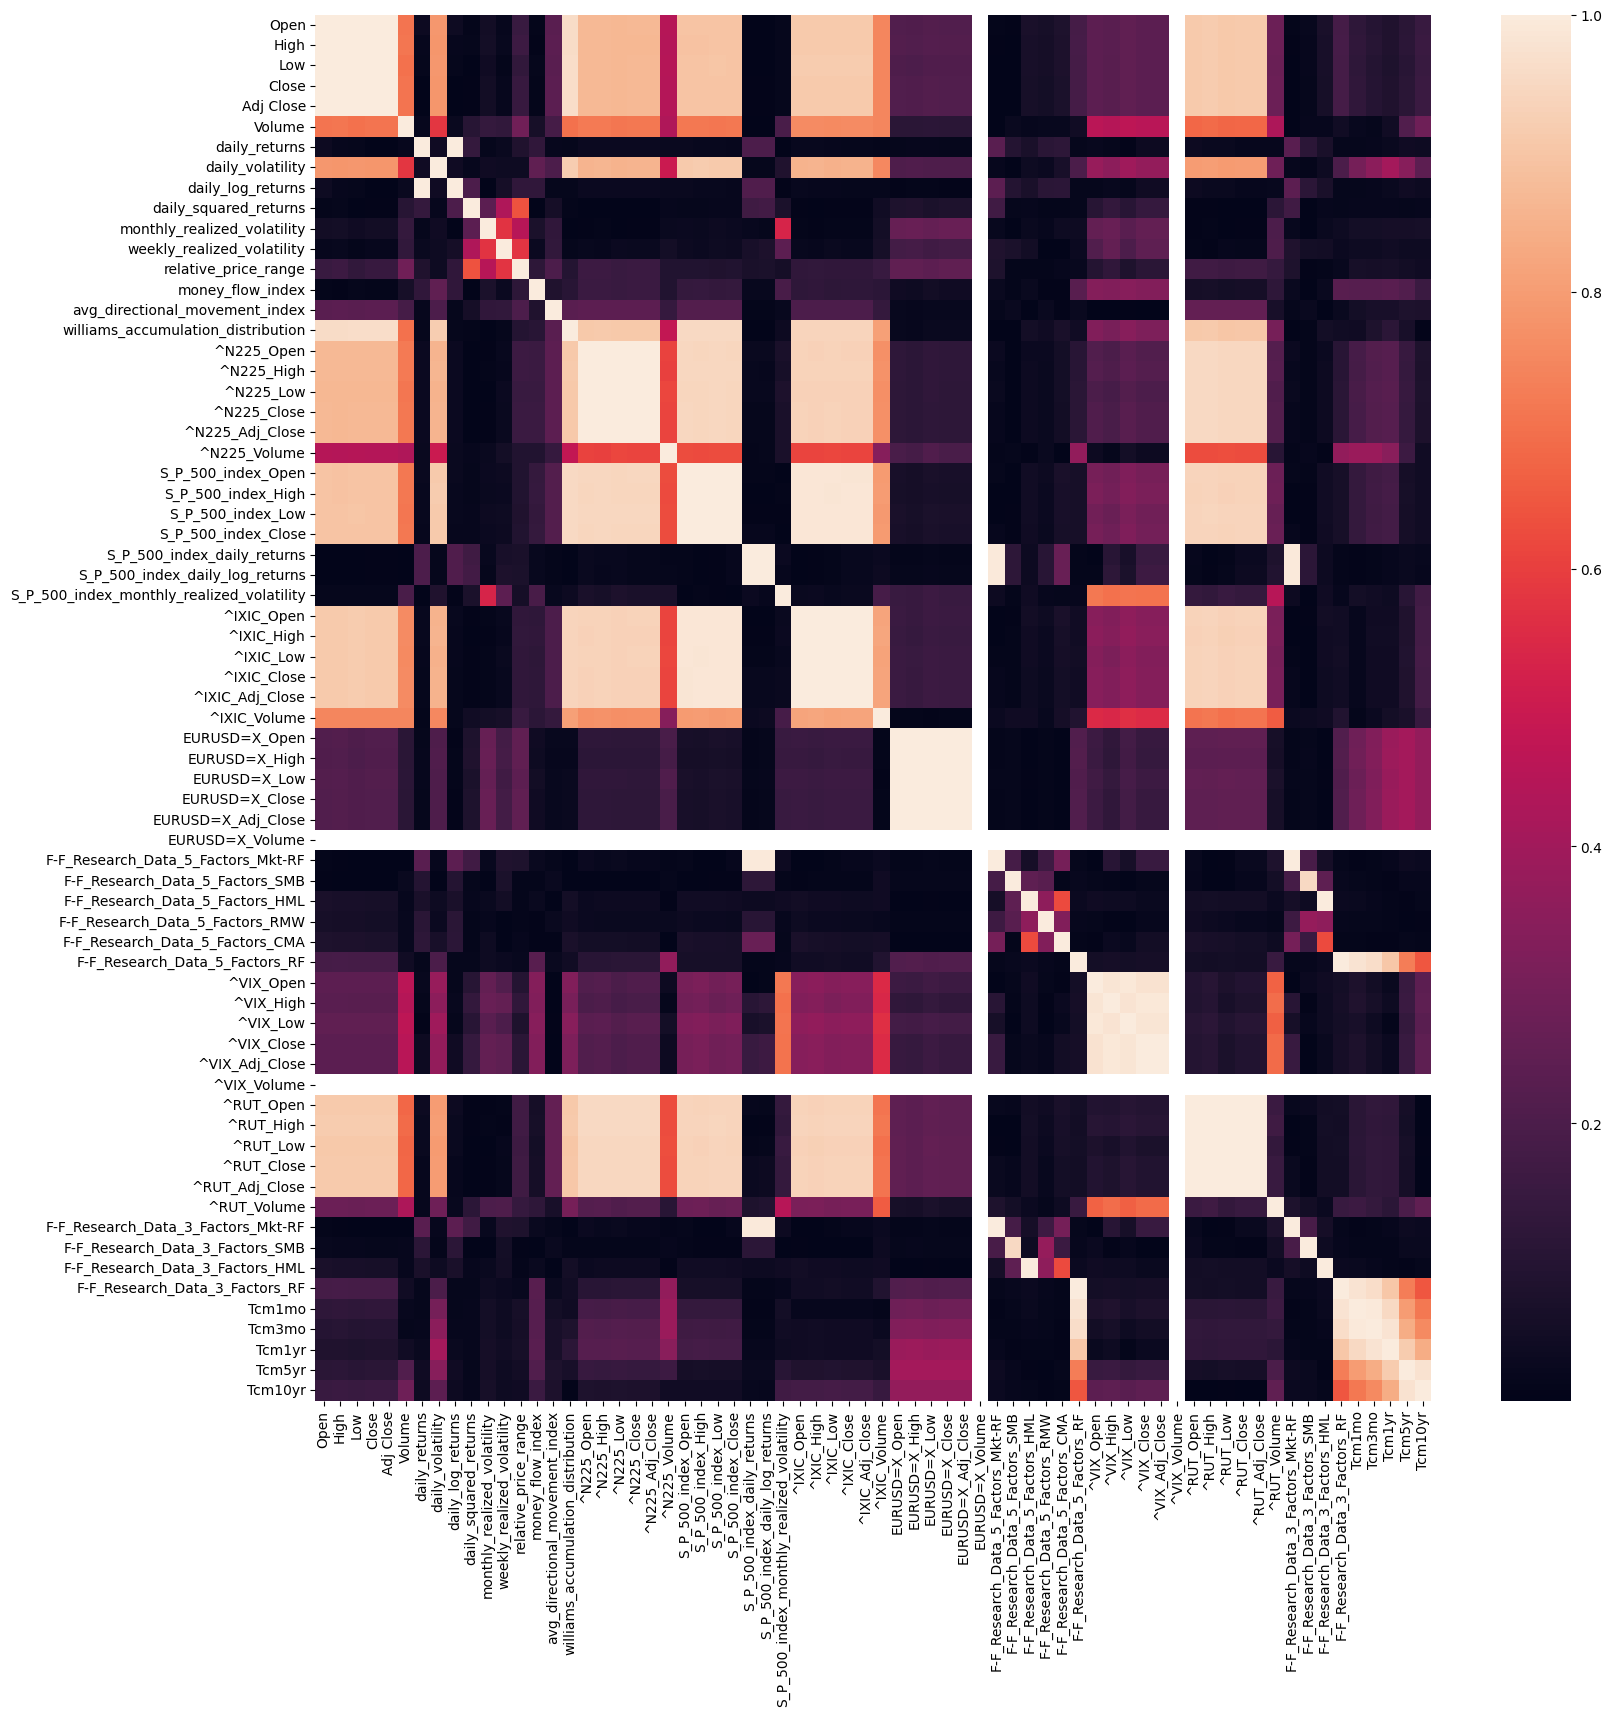

In [17]:
df_asset_corr = abs(df_asset['2015-01-01':].corr())

plt.figure(figsize=(18, 18))
sns.heatmap(
    df_asset_corr,
    xticklabels=df_asset_corr.columns,
    yticklabels=df_asset_corr.columns,
    ax=plt.gca()
)

<Axes: >

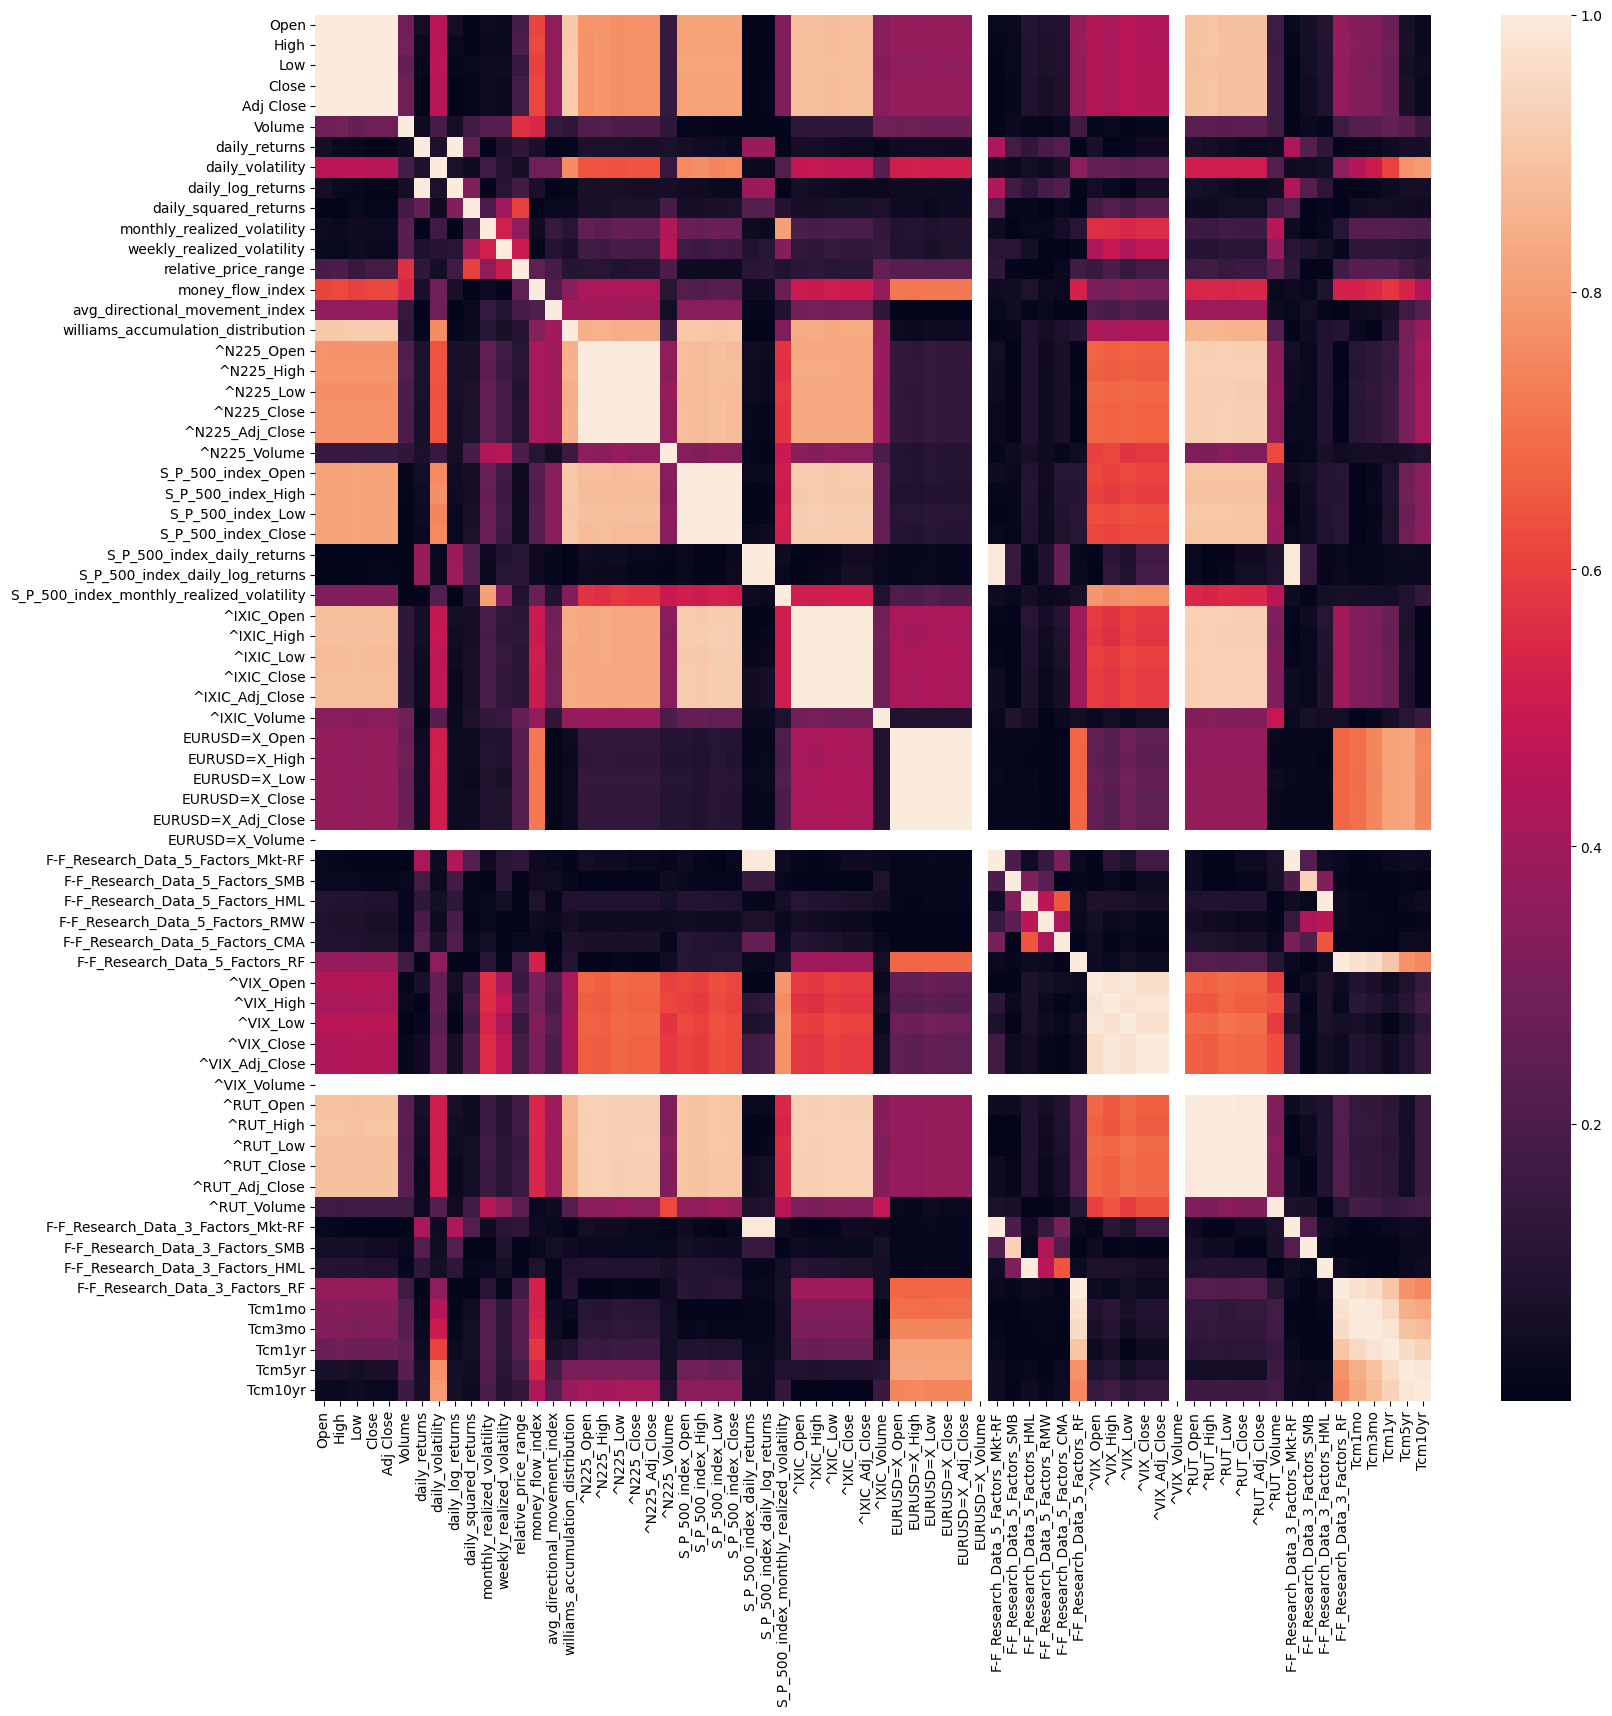

In [18]:
df_asset_corr = abs(df_asset['2020-01-01':].corr())

plt.figure(figsize=(18, 18))
sns.heatmap(
    df_asset_corr,
    xticklabels=df_asset_corr.columns,
    yticklabels=df_asset_corr.columns,
    ax=plt.gca()
)

<Axes: >

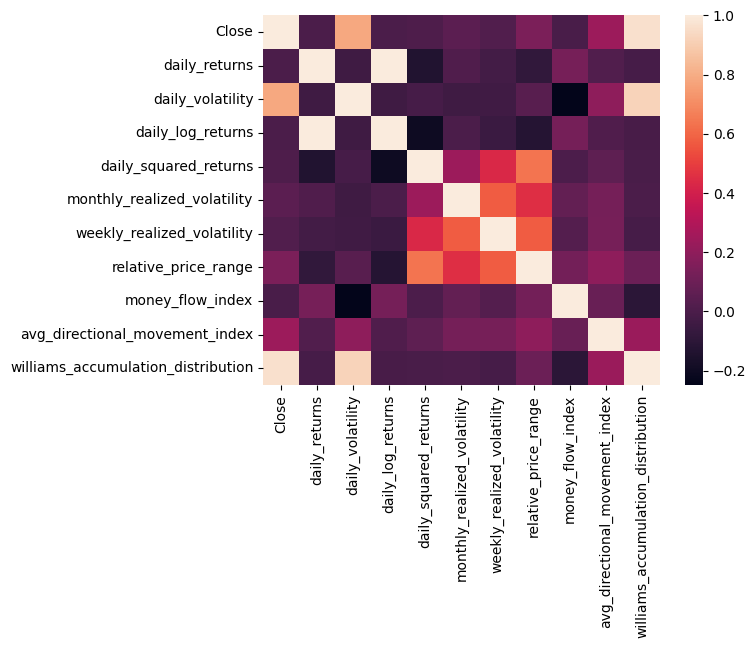

In [19]:
CALC_FEATS = [
    'daily_returns','daily_volatility', 'daily_log_returns', 'daily_squared_returns',
    'monthly_realized_volatility', 'weekly_realized_volatility', 'relative_price_range', 
    'money_flow_index', 'avg_directional_movement_index', 'williams_accumulation_distribution'
    ]

df_asset_corr = df_asset[['Close'] + CALC_FEATS].corr()

sns.heatmap(
    df_asset_corr,
    xticklabels=df_asset_corr.columns,
    yticklabels=df_asset_corr.columns,
)

<Axes: >

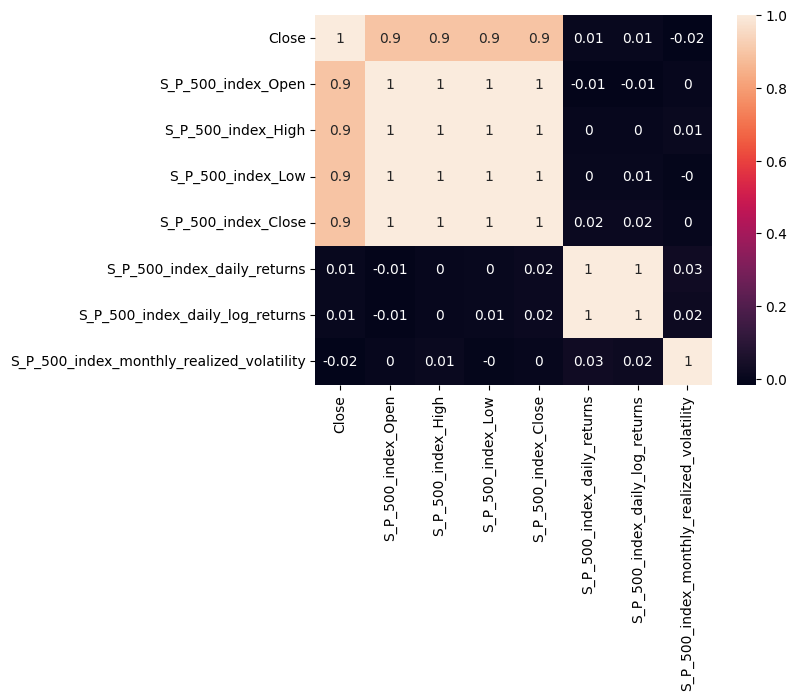

In [32]:
CALC_FEATS = [col for col in df_asset.columns if 'S_P_500' in col]

df_asset_corr = df_asset[['Close'] + CALC_FEATS].corr()

sns.heatmap(
    df_asset_corr,
    xticklabels=df_asset_corr.columns,
    yticklabels=df_asset_corr.columns,
    annot=np.round(df_asset_corr.values, 2),
)

<Axes: >

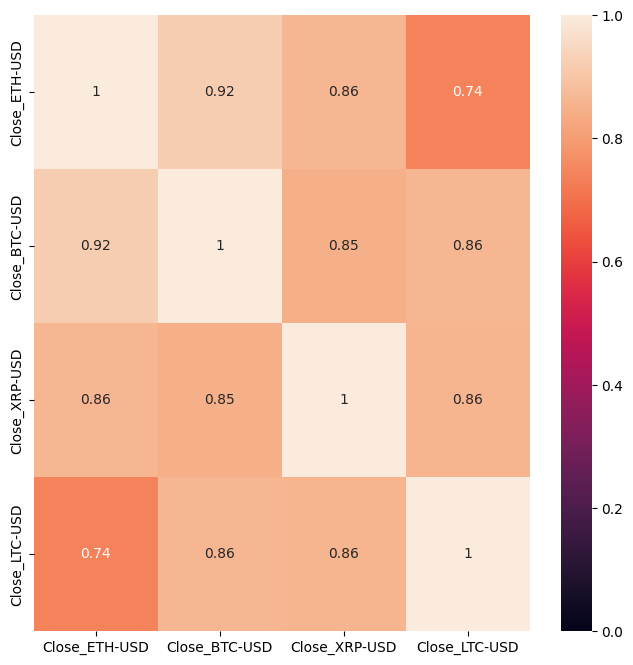

In [21]:
df_close_all_assets = pd.concat([df_asset['Close'].rename(f"Close_{asset_name}") for asset_name, df_asset in dict_assets.items()], axis=1)


TIME_PERIOD_START = '2019-01-01'
TIME_PERIOD_END = None #'2023-01-01'

if TIME_PERIOD_START:
    df_close_all_assets = df_close_all_assets[TIME_PERIOD_START:]
if TIME_PERIOD_END:
    df_close_all_assets = df_close_all_assets[:TIME_PERIOD_END]

df_all_asset_corr = df_close_all_assets.corr()

plt.figure(figsize=(8, 8))
sns.heatmap(
    df_all_asset_corr,
    xticklabels=df_all_asset_corr.columns,
    yticklabels=df_all_asset_corr.columns,
    annot=df_all_asset_corr.values,
    ax=plt.gca(),
    vmin=0,
)

<Axes: >

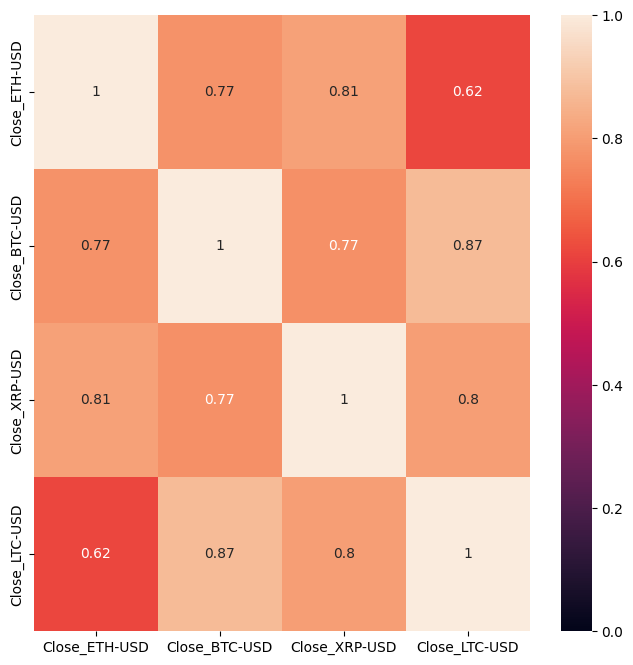

In [22]:
df_close_all_assets = pd.concat([df_asset['Close'].rename(f"Close_{asset_name}") for asset_name, df_asset in dict_assets.items()], axis=1)


TIME_PERIOD_START = '2021-01-01'
TIME_PERIOD_END = None #'2023-01-01'

if TIME_PERIOD_START:
    df_close_all_assets = df_close_all_assets[TIME_PERIOD_START:]
if TIME_PERIOD_END:
    df_close_all_assets = df_close_all_assets[:TIME_PERIOD_END]

df_all_asset_corr = df_close_all_assets.corr()

plt.figure(figsize=(8, 8))
sns.heatmap(
    df_all_asset_corr,
    xticklabels=df_all_asset_corr.columns,
    yticklabels=df_all_asset_corr.columns,
    annot=df_all_asset_corr.values,
    ax=plt.gca(),
    vmin=0,
)

In [23]:
df_close_btc_eth = pd.concat(
    [
        dict_assets['BTC-USD']['Close'].rename("Close_BTC-USD"), 
        dict_assets['ETH-USD']['Close'].rename("Close_ETH-USD"), 
    ], 
    axis=1,
)
df_close_btc_eth = df_close_btc_eth.dropna()
df_close_btc_eth = df_close_btc_eth.resample('1D').first()

corr_btc_eth_mean = pearsonr(df_close_btc_eth['Close_BTC-USD'], df_close_btc_eth['Close_ETH-USD']).statistic
corr_btc_eth_60d_roll = df_close_btc_eth['Close_BTC-USD'].rolling('60D', min_periods=60).corr(df_close_btc_eth['Close_ETH-USD'])

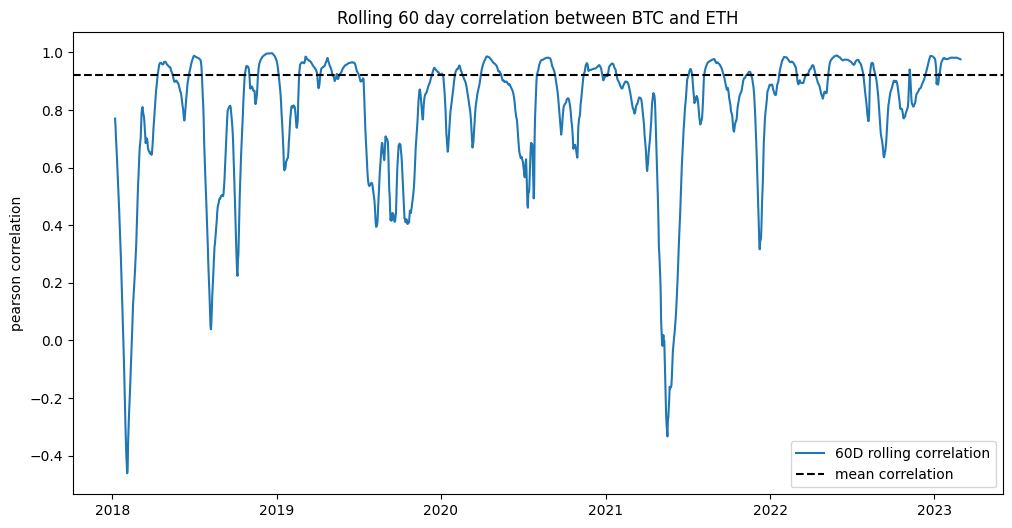

In [24]:
plt.figure(figsize=(12,6))
plt.plot(corr_btc_eth_60d_roll, label='60D rolling correlation')
plt.axhline(corr_btc_eth_mean, color='black', ls='--', label='mean correlation')

plt.title("Rolling 60 day correlation between BTC and ETH")
plt.ylabel("pearson correlation")
plt.legend()

## Descriptive Stats
N, min value, 1st quantile, median, mean, standard deviation, 3rd quantile, max value, skewness, kurtosis

In [25]:
pd.options.display.max_columns = 100

In [75]:
df_close_all_assets = pd.concat([df_asset['Close'].rename(f"Close_{asset_name}") for asset_name, df_asset in dict_assets.items()], axis=1)

df_descriptive_stats = pd.concat([
    df_close_all_assets.describe(), 
    pd.DataFrame(df_close_all_assets.kurtosis(), columns=['kurtosis']).T,
    pd.DataFrame(df_close_all_assets.skew(), columns=['skewness']).T,
])
df_descriptive_stats

Close_ETH-USD  Close_BTC-USD  Close_XRP-USD  Close_LTC-USD
count       1938.000000    2981.000000    1938.000000    2981.000000
mean        1142.440624   13481.524369       0.520195      69.656052
std         1172.103874   16181.118403       0.359689      66.984527
min           84.308296     178.102997       0.139635       1.157010
25%          213.643108     920.382019       0.288724       4.219910
50%          559.634278    7556.237793       0.388867      54.807610
75%         1718.111817   19044.107422       0.656891     100.378006
max         4812.087402   67566.828125       3.377810     386.450775
kurtosis       0.361284       1.130637       9.853790       1.653547
skewness       1.179694       1.472561       2.419911       1.291831

# Regression

In [12]:
df_asset = dict_assets['BTC-USD']

In [13]:
TARGET = 'daily_log_returns'

In [147]:
FEATURES_LIST_HAND_PICKED = [
    'Close', 'daily_volatility',
    'monthly_realized_volatility', 'weekly_realized_volatility',
    'relative_price_range', 'money_flow_index',
    'avg_directional_movement_index', 'williams_accumulation_distribution',
    'on_balance_volume', 'pma_10', 'pma_30', 'pma_60',
    
    'S_P_500_index_Close', #'S_P_500_index_monthly_realized_volatility', 
    'S_P_500_index_daily_log_returns',

    '^N225_Close', '^IXIC_Close', 'EURUSD=X_Close', '^VIX_Close', '^RUT_Close',

    'Tcm1mo', 'Tcm1yr', 'Tcm5yr', 'Tcm10yr',

    # 'F-F_Research_Data_5_Factors_Mkt-RF', 'F-F_Research_Data_5_Factors_SMB',
    # 'F-F_Research_Data_5_Factors_HML', 'F-F_Research_Data_5_Factors_RMW',
    # 'F-F_Research_Data_5_Factors_CMA', 'F-F_Research_Data_5_Factors_RF',

    ## F-F3 are subset of F-F5
    # 'F-F_Research_Data_3_Factors_Mkt-RF', 'F-F_Research_Data_3_Factors_SMB', 
    # 'F-F_Research_Data_3_Factors_HML', 'F-F_Research_Data_3_Factors_RF',
]

len(FEATURES_LIST_HAND_PICKED)

23

<Axes: >

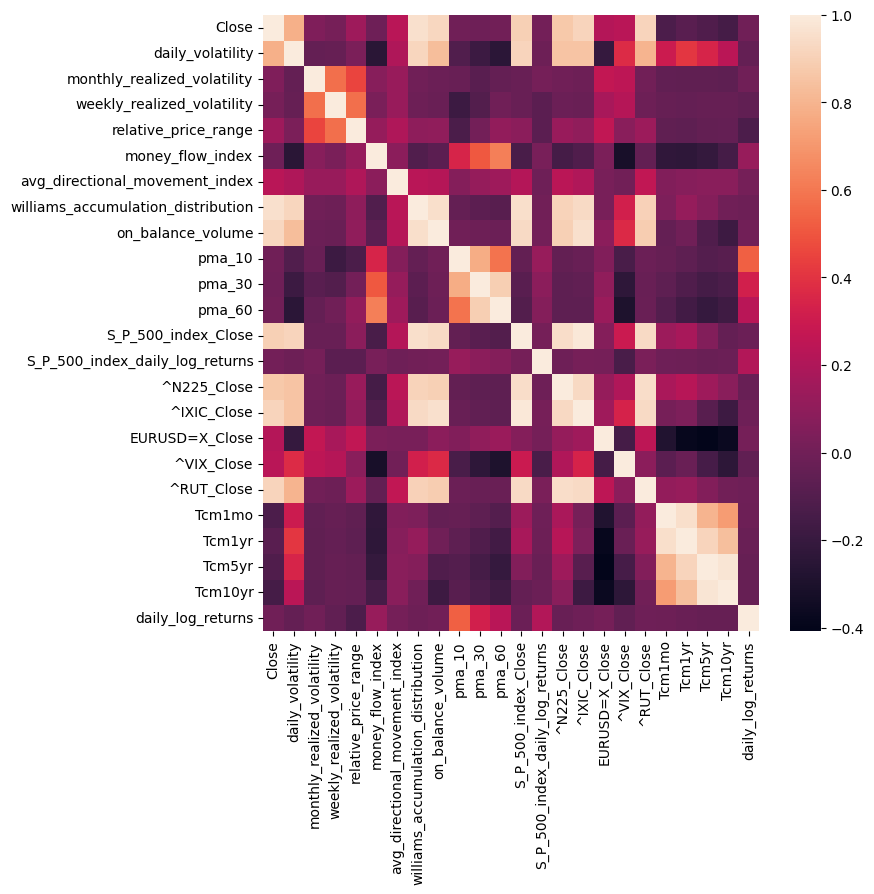

In [148]:
corr = df_asset[FEATURES_LIST_HAND_PICKED+[TARGET]].corr()

plt.figure(figsize=(8, 8))
sns.heatmap(
    corr,
    xticklabels=corr.columns,
    yticklabels=corr.columns,
    # annot=corr.values,
    ax=plt.gca(),
    # vmin=0,
)

In [155]:
TRAIN_DATE_RANGE = ("2018-01-01", "2021-12-31")
TEST_DATE_RANGE = ("2022-01-01", "2022-12-31")
OOS_DATE_RANGE = ("2023-01-01", "2023-02-20")

In [156]:
def train_test_split(df_asset, TRAIN_DATE_RANGE, TEST_DATE_RANGE, OOS_DATE_RANGE, FEATURES_LIST, TARGET, norm=False):
    
    df_asset_tts = df_asset.copy()
    df_asset_tts[TARGET] = df_asset_tts[TARGET].shift(periods=-1)
    df_asset_tts = df_asset_tts[FEATURES_LIST + [TARGET]]
    print(f"{df_asset_tts.shape=}")
    if norm:
        scaler = StandardScaler()
        df_asset_tts[FEATURES_LIST] = scaler.fit_transform(df_asset_tts[FEATURES_LIST])
        with open("./assets/scaler.pkl", "wb") as f:
            pickle.dump(scaler, f)
    
    df_asset_train = df_asset_tts[TRAIN_DATE_RANGE[0]: TRAIN_DATE_RANGE[1]]
    df_asset_test = df_asset_tts[TEST_DATE_RANGE[0]: TEST_DATE_RANGE[1]]
    df_asset_oos = df_asset_tts[OOS_DATE_RANGE[0]: OOS_DATE_RANGE[1]]
    
    X_train, Y_train = df_asset_train[FEATURES_LIST], df_asset_train[TARGET]
    X_test, Y_test = df_asset_test[FEATURES_LIST], df_asset_test[TARGET]
    X_oos, Y_oos = df_asset_oos[FEATURES_LIST], df_asset_oos[TARGET]

    print(f"""
    {X_train.shape=}, {Y_train.shape=}, 
    {X_test.shape=}, {Y_test.shape=},
    {X_oos.shape=}, {Y_oos.shape=},
    """)

    return X_train, Y_train, X_test, Y_test, X_oos, Y_oos

In [157]:
X_train, Y_train, X_test, Y_test, X_oos, Y_oos = train_test_split(
    df_asset=df_asset, 
    TRAIN_DATE_RANGE=TRAIN_DATE_RANGE, 
    TEST_DATE_RANGE=TEST_DATE_RANGE, 
    OOS_DATE_RANGE=OOS_DATE_RANGE,
    FEATURES_LIST=FEATURES_LIST_HAND_PICKED, 
    TARGET=TARGET, 
    norm=False,
    )

df_asset_tts.shape=(2981, 24)

    X_train.shape=(1461, 23), Y_train.shape=(1461,), 
    X_test.shape=(365, 23), Y_test.shape=(365,),
    X_oos.shape=(51, 23), Y_oos.shape=(51,),
    


In [158]:
X_train.describe()

Close  daily_volatility  monthly_realized_volatility  \
count   1461.000000       1461.000000                  1461.000000   
mean   18375.242011       5780.942251                     0.050231   
std    17760.299775       3617.367291                     0.049663   
min     3236.761719       2909.620607                     0.003623   
25%     7116.804199       3826.496687                     0.022477   
50%     9475.277344       3991.343328                     0.034774   
75%    29001.720703       4840.610266                     0.059506   
max    67566.828125      15892.528466                     0.312928   

       weekly_realized_volatility  relative_price_range  money_flow_index  \
count                 1461.000000           1461.000000       1461.000000   
mean                     0.011434              0.049900         52.383831   
std                      0.019013              0.039396          2.115826   
min                      0.000024              0.004611         48.591295   
25%                      0.003273              0.024123         50.624529   
50%                      0.006911              0.040266         52.181503   
75%                      0.013417              0.061445         53.506543   
max                      0.242659              0.479889         60.529573   

       avg_directional_movement_index  williams_accumulation_distribution  \
count                     1461.000000                         1461.000000   
mean                         0.958797                        30631.816191   
std                          0.052040                        26899.916954   
min                          0.697569                         9086.484633   
25%                          0.941723                        12958.157979   
50%                          0.979842                        17179.376229   
75%                          0.995065                        43423.535398   
max                          0.999992                       105875.576406   

       on_balance_volume       pma_10  ...  S_P_500_index_daily_log_returns  \
count       1.461000e+03  1461.000000  ...                      1461.000000   
mean        8.953267e+11     1.004735  ...                         0.000396   
std         7.570834e+11     0.067867  ...                         0.011174   
min         8.946056e+10     0.610077  ...                        -0.127652   
25%         1.951241e+11     0.969754  ...                        -0.001266   
50%         6.087130e+11     1.004452  ...                         0.000000   
75%         1.683672e+12     1.040481  ...                         0.003602   
max         2.687268e+12     1.242924  ...                         0.089683   

        ^N225_Close   ^IXIC_Close  EURUSD=X_Close   ^VIX_Close   ^RUT_Close  \
count   1461.000000   1461.000000     1461.000000  1461.000000  1461.000000   
mean   23874.468032   9977.754762        1.156451    20.109035  1725.601535   
std     3202.304557   2885.019533        0.042438     8.760247   325.800799   
min    16552.830078   6192.919922        1.065735     9.150000   991.159973   
25%    21627.339844   7645.509766        1.122208    14.640000  1522.099976   
50%    22758.480469   8532.360352        1.155976    17.799999  1591.609985   
75%    27013.250000  12807.919922        1.186704    22.750000  1996.250000   
max    30670.099609  16057.440430        1.251001    82.690002  2442.739990   

            Tcm1mo       Tcm1yr       Tcm5yr      Tcm10yr  
count  1461.000000  1461.000000  1461.000000  1461.000000  
mean      0.010897     0.012150     0.015235     0.018465  
std       0.009698     0.010448     0.009371     0.008117  
min       0.000000     0.000400     0.001900     0.005200  
25%       0.000700     0.001200     0.007100     0.012500  
50%       0.014800     0.015400     0.014400     0.016800  
75%       0.020100     0.023000     0.025100     0.027100  
max       0.025100     0.027400     0.030900     0.032400  

[8 rows x 23 columns]

## Fit and Score Regression Models

### ARIMA (Not working)

In [49]:
from pandas.plotting import autocorrelation_plot
from statsmodels.tsa.arima.model import ARIMA

<Axes: xlabel='Lag', ylabel='Autocorrelation'>

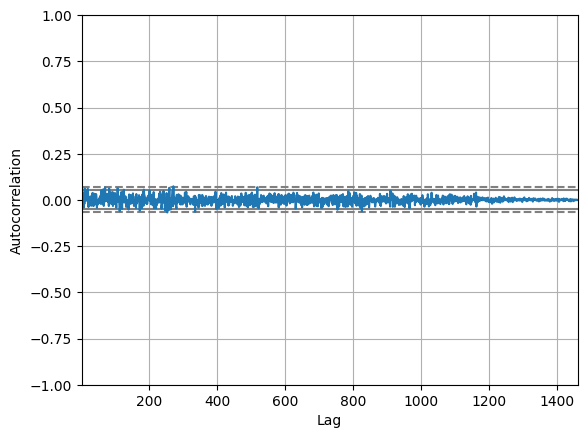

In [48]:
autocorrelation_plot(Y_train)

In [70]:
model_arima = ARIMA(endog=Y_train, exog=X_train, order=(0,1,7))

                               SARIMAX Results                                
Dep. Variable:      daily_log_returns   No. Observations:                 1461
Model:                 ARIMA(0, 1, 7)   Log Likelihood                2786.745
Date:                Tue, 11 Apr 2023   AIC                          -5499.491
Time:                        23:53:12   BIC                          -5303.902
Sample:                    01-01-2017   HQIC                         -5426.528
                         - 12-31-2020                                         
Covariance Type:                  opg                                         
                                         coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------------
Close                                 -0.6285      0.104     -6.046      0.000      -0.832      -0.425
daily_volatility                      -1.1212      0.239   

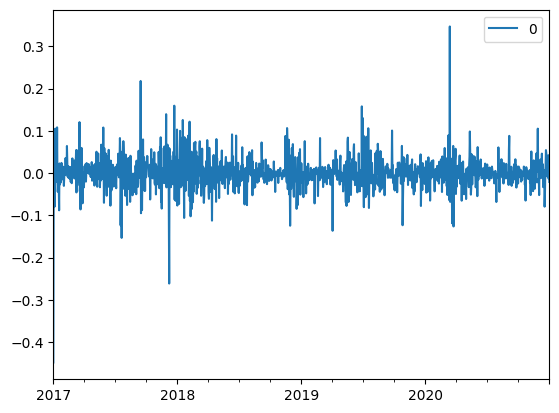

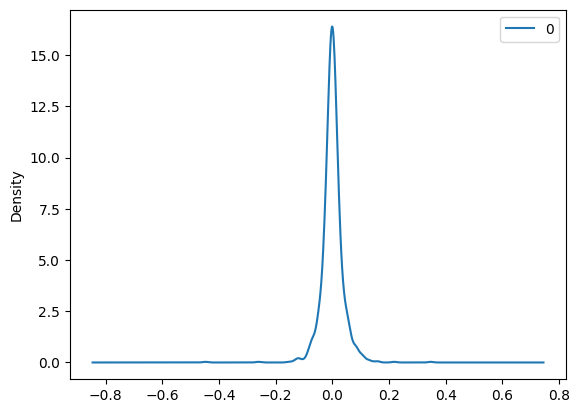

                 0
count  1461.000000
mean      0.000343
std       0.037755
min      -0.448363
25%      -0.015641
50%      -0.000436
75%       0.015390
max       0.346972


In [71]:
model_fit = model_arima.fit()
# summary of fit model
print(model_fit.summary())
# line plot of residuals
residuals = pd.DataFrame(model_fit.resid)
residuals.plot()
plt.show()
# density plot of residuals
residuals.plot(kind='kde')
plt.show()
# summary stats of residuals
print(residuals.describe())

In [74]:
Y_pred_ARIMA = model_fit.forecast(exog=X_test, steps=X_test.shape[0])

In [75]:
r2_score(Y_test, Y_pred_ARIMA)

-95948080.25930463

### Regressions

**Random Forest Regression**

In [ ]:
# Grid-Search for Best Parameters
"""
PARAMS_GS_RFR = {
    "n_estimators": [100, 1000, 5000],
    "criterion": ["squared_error", "absolute_error", "friedman_mse", "poisson"],
    "max_depth": [None],
    "max_features": ["sqrt", "log2", None],
    "min_samples_leaf": [1, 2, 4],
    "min_samples_split": [2, 5, 10],
}

rfr = RandomForestReg({})
rfr.grid_search_CV(
    X_train=X_train, 
    Y_train=Y_train,
    param_grid=PARAMS_GS_RFR,
    cv=None, 
    refit=True,
    scoring='r2', 
    n_jobs=-1, 
    verbose=5,
)
"""

In [159]:
PARAMS_RFR = {
    "n_estimators": 100,
    "criterion": "squared_error",
    "max_depth": None,
    "max_features": None,
    "min_samples_leaf": 1,
}

rfr = RandomForestReg(**PARAMS_RFR)
rfr.fit_regressor(X_train, Y_train)
# make the prediction on the test set
Y_pred = rfr.predict_regressor(X_test)
# make the prediction on the out-of-sampling set
Y_pred_oos = rfr.predict_regressor(X_oos)
rfr.score_regressor(X_test, Y_test)

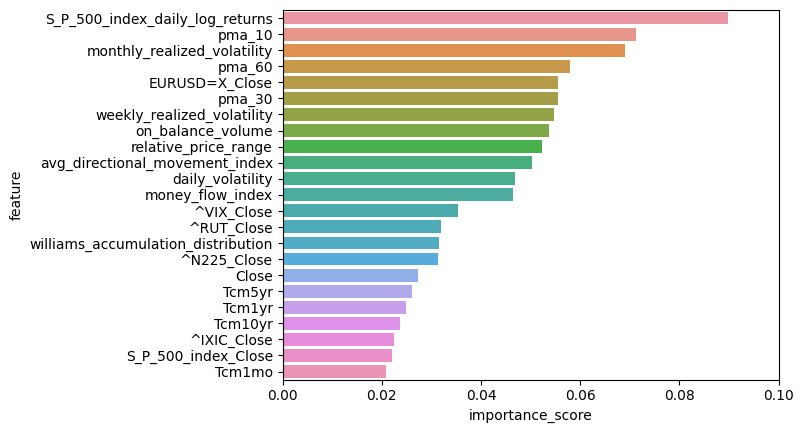

In [160]:
df_feat_imp = pd.DataFrame(
    [X_train.columns, rfr.regressor.feature_importances_], 
    index=["feature", "importance_score"]
    ).T.sort_values(by="importance_score", ascending=False)
sns.barplot(x=df_feat_imp["importance_score"], y=df_feat_imp["feature"], orient="horizonal")
plt.xlim(0, 0.1)
plt.show()

**Histogram Gradient Boosting Regressor**

In [161]:
PARAMS_HGBR = {
    "loss": "squared_error",
    "max_depth": None,
    "validation_fraction": 0.2,
}

hgbr = HistGradientBoostingReg(**PARAMS_HGBR)
hgbr.fit_regressor(X_train, Y_train)
Y_pred = hgbr.predict_regressor(X_test)
hgbr.score_regressor(X_test, Y_test)

**Stochastic Gradient Descent Regressor**

In [71]:
PARAMS_SGDR = {
    "loss": "squared_error",#"squared_error",
    "max_iter": 100,
    "penalty": "l2",
    "validation_fraction": 0.2,
    "early_stopping": True,
    "n_iter_no_change": 10,
    "learning_rate": "optimal",
}

sgdr = SGDReg(scaler="StandardScaler", **PARAMS_SGDR)
sgdr.fit_regressor(X_train, Y_train)
Y_pred = sgdr.predict_regressor(X_test)
sgdr.score_regressor(X_test, Y_test)

**Elastic Net Regressor**

In [72]:
PARAMS_ENR = {
    # "loss": "squared_error",
    # "max_depth": None,
    # "validation_fraction": 0.2,
}

enr = ElasticNetReg(**PARAMS_ENR)
enr.fit_regressor(X_train, Y_train)
Y_pred = enr.predict_regressor(X_test)
enr.score_regressor(X_test, Y_test)

**ThielSen Regressor**

In [73]:
PARAMS_TSR = {
    # "loss": "squared_error",
    # "max_depth": None,
    # "validation_fraction": 0.2,
}

tsr = TheilSenReg(**PARAMS_TSR)
tsr.fit_regressor(X_train, Y_train)
Y_pred = tsr.predict_regressor(X_test)
tsr.score_regressor(X_test, Y_test)

**RANSAC Regressor**

In [74]:
PARAMS_RANSACR = {
    # "loss": "squared_error",
    # "max_depth": None,
    # "validation_fraction": 0.2,
}

ransacr = RANSACReg(**PARAMS_RANSACR)
ransacr.fit_regressor(X_train, Y_train)
Y_pred = ransacr.predict_regressor(X_test)
ransacr.score_regressor(X_test, Y_test)

## Plot Prediction

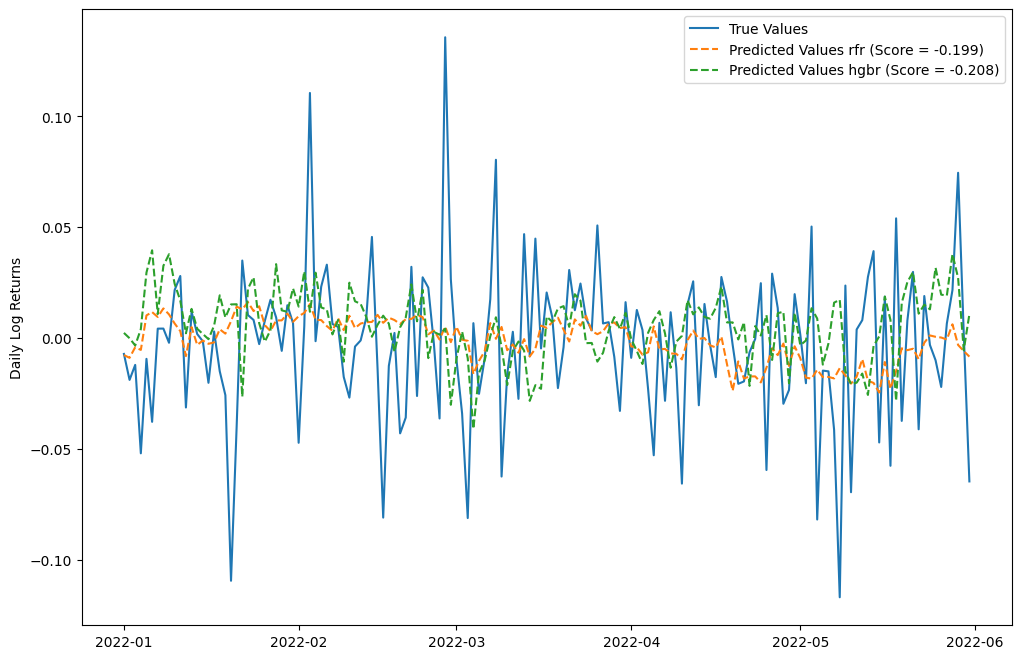

In [162]:
## Rest of the models are not good :(\
## But the problem is idk the theory there, so IDK how to make them better (even if possible in the first place)

dict_regressors = {
    "rfr": rfr, 
    "hgbr": hgbr, 
    # "sgdr": sgdr, 
    # "enr": enr, 
    # "tsr": tsr, 
    # "ransacr": ransacr,
}

plt.figure(figsize=(12, 8))

PLOT_RANGE = ("2022-01-01", "2022-05-31")

plt.plot(Y_test[PLOT_RANGE[0]: PLOT_RANGE[1]], label="True Values")

for regressor_name, regressor in dict_regressors.items():
    # if regressor_name=='sgdr':
    #     continue
    plt.plot(
        regressor.predict_regressor(X_test)[PLOT_RANGE[0]: PLOT_RANGE[1]],
        label=f"Predicted Values {regressor_name} (Score = {round(regressor.score, 3)})",
        ls='--',
    )

# plt.plot(
#     Y_pred_ARIMA[PLOT_RANGE[0]: PLOT_RANGE[1]],
#     label=f"Predicted Values ARIMA (Score = {r2_score(Y_test, Y_pred_ARIMA)})",
#     ls='--'
#     )
# plt.title(f"Score= {round(rfr.score, 3)}")
plt.ylabel("Daily Log Returns")
plt.legend()
plt.show()

# Trading Strategy

In [163]:
# initialize this as the object of the chosen regression model
regression_model = rfr
# select the appropriate set to evaluate on
VALIDATIION_SET = 'out-of-sampling' # 'test' or 'out-of-sampling'

In [180]:
if VALIDATIION_SET == 'test':
    ds_daily_log_returns_pred = regression_model.predict_regressor(X_test)
    ds_daily_log_returns_true = Y_test
elif VALIDATIION_SET == 'out-of-sampling':
    ds_daily_log_returns_pred = regression_model.predict_regressor(X_oos)
    ds_daily_log_returns_true = Y_oos

**Trading Strategy from chosen regression model**

In [165]:
ds_close_pred = regression_model.calc_price_from_daily_log_returns(ds_daily_log_returns_pred, price_var='Close')
regression_trading_strategy = TradingStrategy(ds_daily_log_returns_pred, ds_close_pred)

**Trading Strategy from True Values**

In [168]:
if VALIDATIION_SET == 'test':
    true_ts = TradingStrategy(Y_test, X_test['Close'])
elif VALIDATIION_SET == 'out-of-sampling':
    true_ts = TradingStrategy(Y_oos, X_oos['Close'])

## Compare Baseline

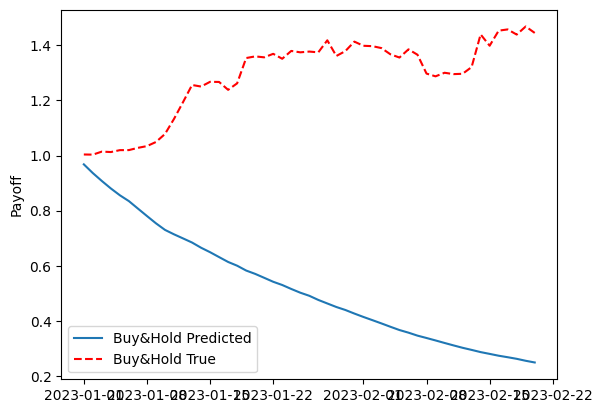

In [169]:
regression_baseline = regression_trading_strategy.strategy_buy_and_hold()
true_baseline = true_ts.strategy_buy_and_hold()

plt.plot(regression_baseline, label='Buy&Hold Predicted')
# plt.plot(df_rfr_payoffs['payoff_SMA_7'])
# ax2 = plt.twinx()
plt.plot(true_baseline, color='red', ls='--', label='Buy&Hold True')
plt.ylabel("Payoff")
plt.legend()
plt.show()

In [170]:
list_strategies = [
    'SMA_7', 'SMA_30', 'SMA_90', 'SMA_180', 
    'EMA_7', 'EMA_30', 'EMA_90', 'EMA_180', 
    'BBS_7', 'BBS_14', 'BBS_30', 
    'RSI_7', 'RSI_14', 'RSI_30'
    ]

df_regression_payoffs = regression_trading_strategy.apply_strategy(list_strategies, return_payoff=True)

In [171]:
df_regression_payoffs#[[col for col in df_regression_payoffs.columns if col.startswith("signal")]]

signal_SMA_7  payoff_SMA_7  signal_SMA_30  payoff_SMA_30  \
2023-01-01             0      1.000000              0       1.000000   
2023-01-02             0      1.000000              0       1.000000   
2023-01-03             0      1.000000              0       1.000000   
2023-01-04             0      1.000000              0       1.000000   
2023-01-05             0      1.000000              0       1.000000   
2023-01-06             0      1.000000              0       1.000000   
2023-01-07             0      1.000000              0       1.000000   
2023-01-08            -1      1.033333              0       1.000000   
2023-01-09            -1      1.068416              0       1.000000   
2023-01-10            -1      1.102164              0       1.000000   
2023-01-11            -1      1.126427              0       1.000000   
2023-01-12            -1      1.149766              0       1.000000   
2023-01-13            -1      1.174389              0       1.000000   
2023-01-14            -1      1.206724              0       1.000000   
2023-01-15            -1      1.236134              0       1.000000   
2023-01-16            -1      1.269916              0       1.000000   
2023-01-17            -1      1.305339              0       1.000000   
2023-01-18            -1      1.334250              0       1.000000   
2023-01-19            -1      1.373248              0       1.000000   
2023-01-20            -1      1.401801              0       1.000000   
2023-01-21            -1      1.436763              0       1.000000   
2023-01-22            -1      1.473978              0       1.000000   
2023-01-23            -1      1.505714              0       1.000000   
2023-01-24            -1      1.546499              0       1.000000   
2023-01-25            -1      1.587043              0       1.000000   
2023-01-26            -1      1.622568              0       1.000000   
2023-01-27            -1      1.672187              0       1.000000   
2023-01-28            -1      1.717309              0       1.000000   
2023-01-29            -1      1.764683              0       1.000000   
2023-01-30            -1      1.807087              0       1.000000   
2023-01-31            -1      1.860390             -1       1.029497   
2023-02-01            -1      1.913910             -1       1.059114   
2023-02-02            -1      1.967734             -1       1.088898   
2023-02-03            -1      2.025505             -1       1.120867   
2023-02-04            -1      2.088778             -1       1.155881   
2023-02-05            -1      2.153884             -1       1.191909   
2023-02-06            -1      2.209662             -1       1.222776   
2023-02-07            -1      2.276485             -1       1.259754   
2023-02-08            -1      2.332622             -1       1.290819   
2023-02-09            -1      2.393740             -1       1.324640   
2023-02-10            -1      2.460171             -1       1.361401   
2023-02-11            -1      2.528628             -1       1.399284   
2023-02-12            -1      2.598653             -1       1.438034   
2023-02-13            -1      2.664261             -1       1.474340   
2023-02-14            -1      2.736442             -1       1.514283   
2023-02-15            -1      2.798103             -1       1.548405   
2023-02-16            -1      2.864389             -1       1.585087   
2023-02-17            -1      2.921440             -1       1.616657   
2023-02-18            -1      2.984591             -1       1.651604   
2023-02-19            -1      3.065471             -1       1.696361   
2023-02-20            -1      3.139263             -1       1.737195   

            signal_SMA_90  payoff_SMA_90  signal_SMA_180  payoff_SMA_180  \
2023-01-01              0            1.0               0             1.0   
2023-01-02              0            1.0               0             1.0   
2023-01-03              0            1.

In [172]:
list_strategies = [
    'SMA_7', 'SMA_30', 'SMA_90', 'SMA_180', 
    'EMA_7', 'EMA_30', 'EMA_90', 'EMA_180', 
    'BBS_7', 'BBS_14', 'BBS_30', 
    'RSI_7', 'RSI_14', 'RSI_30'
    ]

df_true_payoffs = true_ts.apply_strategy(list_strategies, return_payoff=True)

In [173]:
df_true_payoffs#[[col for col in df_true_payoffs.columns if col.startswith("payoff")]]

signal_SMA_7  payoff_SMA_7  signal_SMA_30  payoff_SMA_30  \
2023-01-01             0      1.000000              0       1.000000   
2023-01-02             0      1.000000              0       1.000000   
2023-01-03             0      1.000000              0       1.000000   
2023-01-04             0      1.000000              0       1.000000   
2023-01-05             0      1.000000              0       1.000000   
2023-01-06             0      1.000000              0       1.000000   
2023-01-07             0      1.000000              0       1.000000   
2023-01-08             1      1.006149              0       1.000000   
2023-01-09             1      1.020655              0       1.000000   
2023-01-10             1      1.048847              0       1.000000   
2023-01-11             1      1.102132              0       1.000000   
2023-01-12             1      1.161260              0       1.000000   
2023-01-13             1      1.221869              0       1.000000   
2023-01-14             1      1.216294              0       1.000000   
2023-01-15             1      1.233003              0       1.000000   
2023-01-16             1      1.232530              0       1.000000   
2023-01-17             1      1.204684              0       1.000000   
2023-01-18             1      1.227640              0       1.000000   
2023-01-19             1      1.316870              0       1.000000   
2023-01-20             1      1.322726              0       1.000000   
2023-01-21             1      1.319400              0       1.000000   
2023-01-22             1      1.331770              0       1.000000   
2023-01-23             1      1.314354              0       1.000000   
2023-01-24             1      1.342012              0       1.000000   
2023-01-25             1      1.337064              0       1.000000   
2023-01-26             1      1.339729              0       1.000000   
2023-01-27             1      1.336961              0       1.000000   
2023-01-28             1      1.379438              0       1.000000   
2023-01-29             1      1.324127              0       1.000000   
2023-01-30            -1      1.306897              0       1.000000   
2023-01-31             1      1.339498              1       1.024946   
2023-02-01             1      1.325199              1       1.014005   
2023-02-02             1      1.323926              1       1.013030   
2023-02-03             1      1.317277              1       1.007942   
2023-02-04            -1      1.338688              1       0.991559   
2023-02-05            -1      1.350141              1       0.983076   
2023-02-06            -1      1.320559              1       1.004615   
2023-02-07             1      1.301987              1       0.990486   
2023-02-08            -1      1.367182              1       0.940890   
2023-02-09            -1      1.377740             -1       0.948156   
2023-02-10            -1      1.363831             -1       0.938584   
2023-02-11            -1      1.368996             -1       0.942138   
2023-02-12            -1      1.367746             -1       0.941278   
2023-02-13            -1      1.342104             -1       0.923632   
2023-02-14             1      1.462585             -1       0.840717   
2023-02-15             1      1.420817              1       0.816708   
2023-02-16             1      1.476379              1       0.848646   
2023-02-17             1      1.480920              1       0.851257   
2023-02-18             1      1.461950              1       0.840352   
2023-02-19             1      1.491781              1       0.857500   
2023-02-20             1      1.467993              1       0.843826   

            signal_SMA_90  payoff_SMA_90  signal_SMA_180  payoff_SMA_180  \
2023-01-01              0            1.0               0             1.0   
2023-01-02              0            1.0               0             1.0   
2023-01-03              0            1.

# Performance

In [181]:
df_regression_signals = df_regression_payoffs[[col for col in df_regression_payoffs.columns if col.startswith("signal")]]
signal_buy_and_hold = pd.Series(
    data=[1]*len(df_regression_signals), 
    index=df_regression_signals.index,
    name="signal_buy_and_hold", 
    )
df_regression_signals = pd.concat([df_regression_signals, signal_buy_and_hold], axis=1)
perf_m = PerformanceMetrics(
    ds_daily_log_returns_true, 
    df_regression_signals,
)

In [182]:
performance_metrics = [
    'cumulative_return', 'annualized_return', 'average_daily_log_returns', 
    'annualized_volatility', 'sharpe_ratio', 'annualized_sharpe_ratio', 
    'sortino_ratio', 'max_drawdown', 'calmar_ratio',
    ]

df_performance_metrics_last, df_performance_metrics = perf_m.compute_performance_metrics(performance_metrics)
df_performance_metrics_last

signal_SMA_7 signal_SMA_30 signal_SMA_90  \
cumulative_return            -0.313133     -0.060879           0.0   
annualized_return            -0.931998     -0.362072           0.0   
average_daily_log_returns     -0.00701     -0.001069          -0.0   
annualized_volatility         0.488199      0.341787           0.0   
sharpe_ratio                 -0.274328     -0.059777           NaN   
annualized_sharpe_ratio      -5.241025     -1.142045           NaN   
sortino_ratio                -0.304559      -0.06519           NaN   
max_drawdown                  2.792785      2.792785           NaN   
calmar_ratio                 -0.333716     -0.129645           NaN   

                          signal_SMA_180 signal_EMA_7 signal_EMA_30  \
cumulative_return                    0.0    -0.329394     -0.329394   
annualized_return                    0.0    -0.942714     -0.942714   
average_daily_log_returns           -0.0    -0.007478     -0.007478   
annualized_volatility                0.0     0.487355      0.487355   
sharpe_ratio                         NaN    -0.293129     -0.293129   
annualized_sharpe_ratio              NaN    -5.600219     -5.600219   
sortino_ratio                        NaN    -0.332839     -0.332839   
max_drawdown                         NaN     2.792785      2.792785   
calmar_ratio                         NaN    -0.337553     -0.337553   

                          signal_EMA_90 signal_EMA_180 signal_BBS_7  \
cumulative_return             -0.329394      -0.329394          0.0   
annualized_return             -0.942714      -0.942714          0.0   
average_daily_log_returns     -0.007478      -0.007478         -0.0   
annualized_volatility          0.487355       0.487355          0.0   
sharpe_ratio                  -0.293129      -0.293129          NaN   
annualized_sharpe_ratio       -5.600219      -5.600219          NaN   
sortino_ratio                 -0.332839      -0.332839          NaN   
max_drawdown                   2.792785       2.792785          NaN   
calmar_ratio                  -0.337553      -0.337553          NaN   

                          signal_BBS_14 signal_BBS_30 signal_RSI_7  \
cumulative_return                   0.0           0.0     0.416735   
annualized_return                   0.0           0.0    11.099073   
average_daily_log_returns          -0.0          -0.0     0.007167   
annualized_volatility               0.0           0.0     0.487829   
sharpe_ratio                        NaN           NaN     0.280674   
annualized_sharpe_ratio             NaN           NaN     5.362262   
sortino_ratio                       NaN           NaN     0.555831   
max_drawdown                        NaN           NaN     1.557792   
calmar_ratio                        NaN           NaN     7.124877   

                          signal_RSI_14 signal_RSI_30 signal_buy_and_hold  
cumulative_return              0.150287      0.061455            0.444725  
annualized_return              1.723846      0.532407           12.917468  
average_daily_log_returns      0.002994      0.001325            0.007552  
annualized_volatility          0.431504       0.34326            0.487035  
sharpe_ratio                   0.132547      0.073722            0.296249  
annualized_sharpe_ratio        2.532309      1.408449            5.659823  
sortino_ratio                  0.246437      0.136828            0.574929  
max_drawdown                   1.557792      1.557792            1.557792  
calmar_ratio                   1.106596       0.34177            8.292168

## Plots to analyse trading strategies across performance metrics

**Comapre Cumulative Returns**

In [183]:
metric = 'cumulative_return'

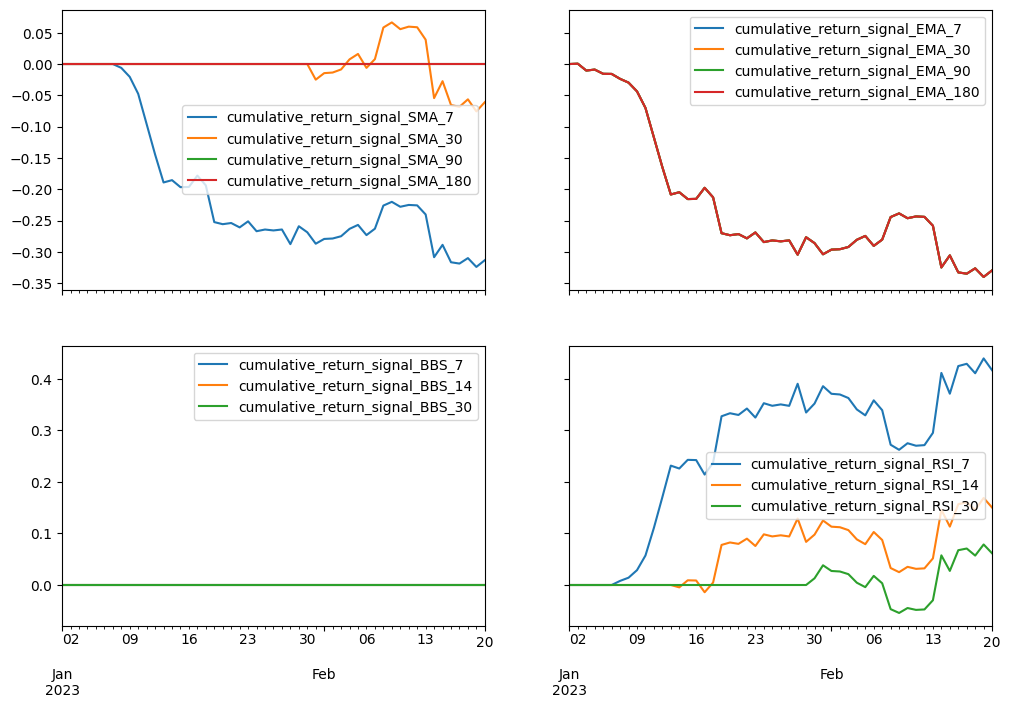

In [184]:
STRATEGY_CATEGORIES = ['SMA', 'EMA', 'BBS', 'RSI']

nrows=2
ncols=2
fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(12, 8), sharey='row', sharex=True)
for i, strategy in enumerate(STRATEGY_CATEGORIES):
    ax = axs[i//ncols][i%ncols]
    df_plot = df_performance_metrics[[col for col in df_performance_metrics.columns if metric in col and strategy in col]]
    df_plot.plot(ax=ax)
plt.show()

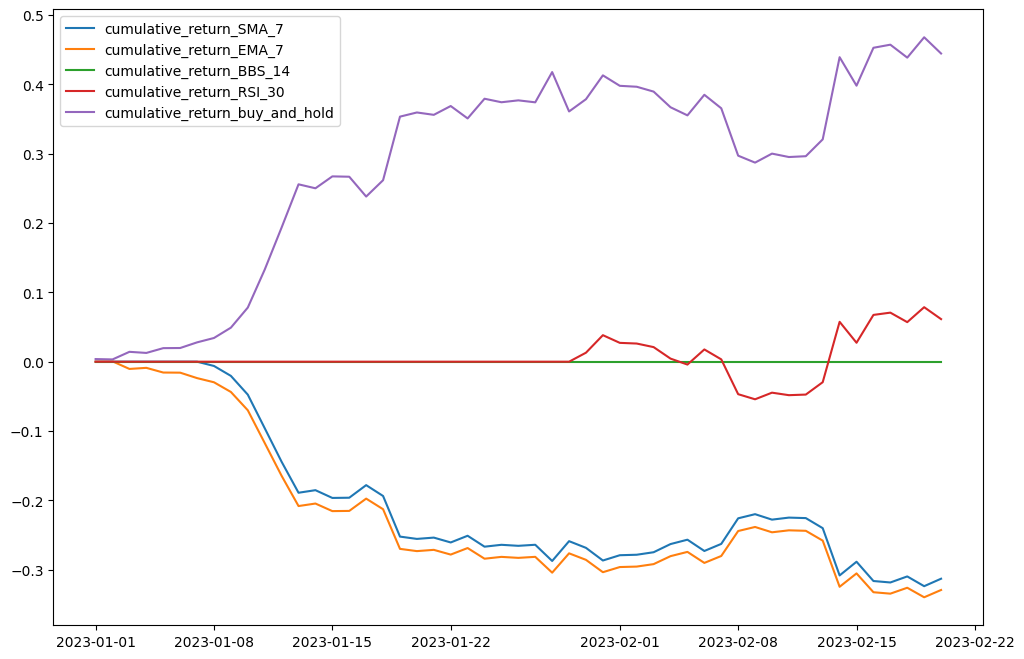

In [185]:
BEST_STRATEGIES = ['SMA_7', 'EMA_7', 'BBS_14', 'RSI_30', 'buy_and_hold']

nrows=1
ncols=1
fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(12, 8), sharey='row', sharex=True)
for strategy in BEST_STRATEGIES:
    ax.plot(df_performance_metrics[f'{metric}_signal_{strategy}'], label=f"{metric}_{strategy}")
# ax.plot(regression_baseline-1, label=f"{metric}_buy_and_hold")
plt.legend()
plt.show()

**Comapre Sharpe Ratio**

In [186]:
metric = 'sharpe_ratio'

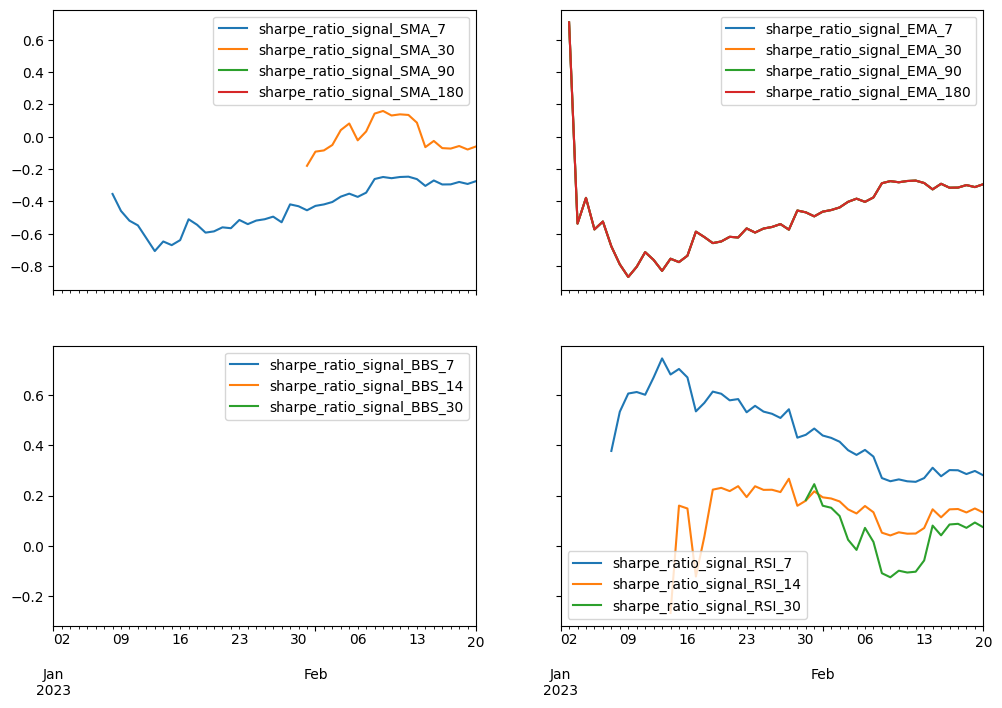

In [187]:
STRATEGY_CATEGORIES = ['SMA', 'EMA', 'BBS', 'RSI']

nrows=2
ncols=2
fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(12, 8), sharey='row', sharex=True)
for i, strategy in enumerate(STRATEGY_CATEGORIES):
    ax = axs[i//ncols][i%ncols]
    df_plot = df_performance_metrics[[col for col in df_performance_metrics.columns if col.startswith(metric) and strategy in col]]
    df_plot.plot(ax=ax)
plt.show()

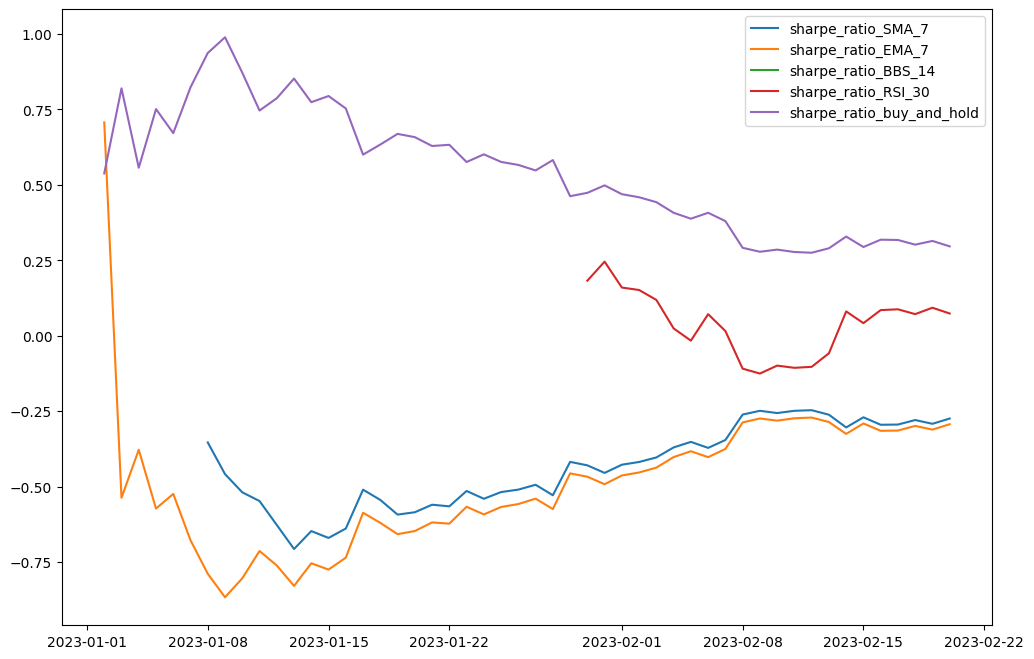

In [188]:
BEST_STRATEGIES = ['SMA_7', 'EMA_7', 'BBS_14', 'RSI_30', 'buy_and_hold']

nrows=1
ncols=1
fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(12, 8), sharey='row', sharex=True)
for strategy in BEST_STRATEGIES:
    plt.plot(df_performance_metrics[f'{metric}_signal_{strategy}'], label=f"{metric}_{strategy}")
plt.legend()
plt.show()